<header style="background-color: #ffe3f7; padding: 10px;">
    <h1 style="text-align: center; font-family: Segoe UI; font-size: 36px; color: #222;"><b>Kidney Stone Prediction</b></h1>
</header>

> **Playground Series - Season 3, Episode 12**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Kidney Stone Prediction based on Urine Analysis](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis) dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

> **Features**

- `id`: Observation ID
- `ph`: PH of urine
- `osmo`: Osmolarity of urine
- `cond`: Conductivity of urine
- `urea`: Concentration of urea in urine
- `calc`: Concentration of calcium in urine
- `target`: 0 - Absence of stone; 1 - Presence of stone

> **Table of Contents**

- [Libraries](#Libraries)
- [Exploring the Dataset](#Importing-the-Dataset)
- [Feature Engineering](#Feature-Engineering)
    - [Combining Features](#Combining-Features)
    - [Cluster Analysis](#Cluster-Analysis)
    - [Preparing the Data](#Preparing-the-Data)
- [Fitting the Data](#Fitting-the-Data)
    - [Stochastic Gradient Descent](#Stochastic-Gradient-Descent)
    - [CatBoost Classifier](#CatBoost-Classifier)
    - [Logistic Regression](#Logistic-Regression)
    - [Support Vector Machines](#Support-Vector-Machines)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [XGBoost Classifier](#XGBoost-Classifier)
    - [MLP Classifier](#MLP-Classifier)
    - [Naive Bayes](#Naive-Bayes)
    - [KNeighbors Classifier](#KNeighbors-Classifier)
    - [AdaBoost](#AdaBoost)
- [Model Score](#Model-Scores)
- [Predicting Kidney Stone](#Predicting-Kidney-Stone)
___

<br><br>

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '2'

In [2]:
def plot_precision_recall_vs_threshold(axis, precisions, recalls, thresholds):
    axis.plot(thresholds, precisions[:-1], "b--", label="Precision")
    axis.plot(thresholds, recalls[:-1], "g-", label="Recall")
    axis.legend(["Precision", "Recall"])
    axis.set_title("Precision/Recall vs. Thresholds")
    axis.set_xlabel("Thresholds")

def plot_roc_curve(axis, fpr, tpr, label=None):
    axis.plot(fpr, tpr, linewidth=2, label=label)
    axis.plot([0,1], [0,1], "k--")
    axis.grid(True)
    axis.set_title("ROC Curve")
    axis.set_xlabel("FPR")
    axis.set_ylabel("TPR")

## Libraries

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import SGDClassifier
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [4]:
model_scores = pd.DataFrame(columns=["Model", "Accuracy", "AUC"])

## Exploring the Dataset

In [5]:
# Importing the data
data = pd.read_csv("./data/playground-series-s3e12/train.csv")

In [6]:
# Looking at first 5 obs
data.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [7]:
# Printing out the dataset shape
print(f"The shape of the dataset is {data.shape}.")

The shape of the dataset is (414, 8).


In [8]:
# Dropping the id col, as it's not relevant
data.drop(["id"], axis=1, inplace=True)

In [9]:
# Getting the dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 22.8 KB


In [10]:
# Summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


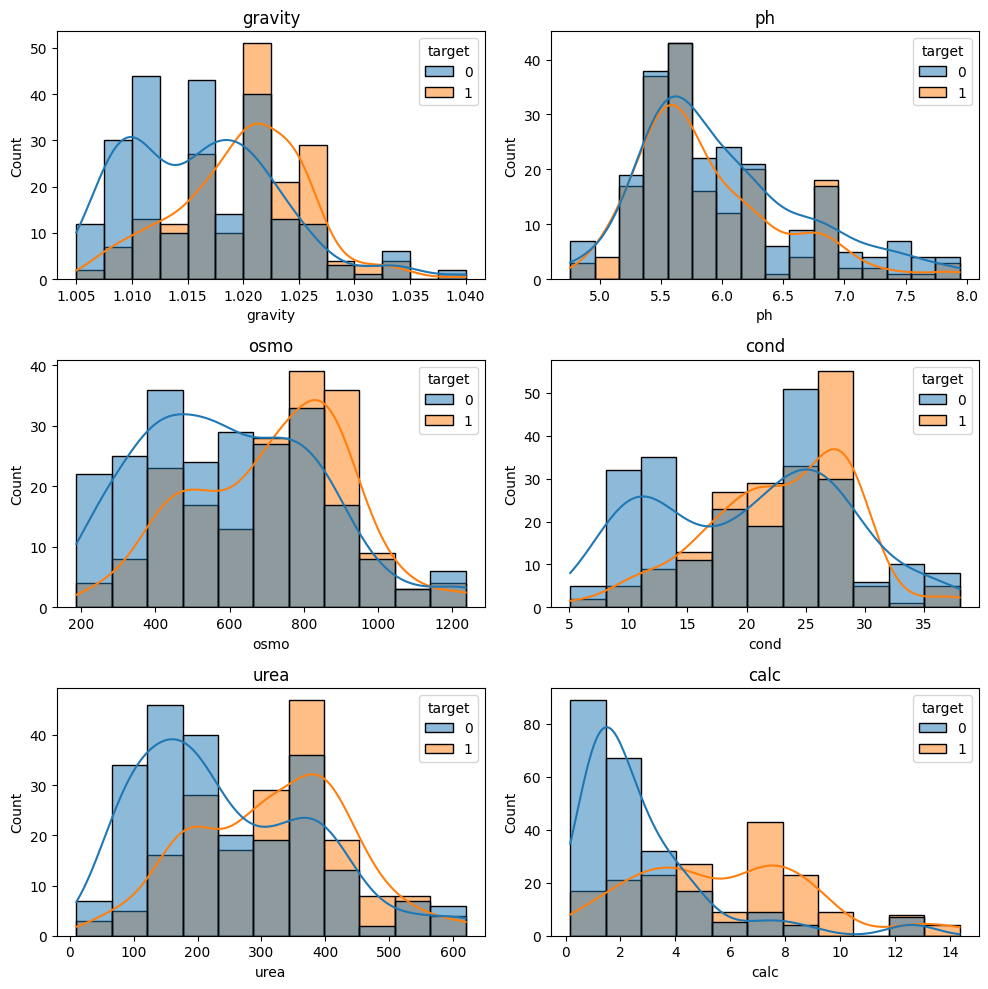

In [11]:
# Plotting histograms
def plot_histograms(data, columns, hue, nrows, ncols):
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    # Flatten the axes array to simplify indexing
    axes = axes.flatten()

    # Plot a histogram of each column on a separate subplot
    for i, column in enumerate(columns):
        sns.histplot(data=data, x=column, hue=hue, ax=axes[i], kde=True)
        axes[i].set_title(column)

    # Remove any unused subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot_histograms(data, ["gravity", "ph", "osmo", "cond", "urea", "calc"], "target", 3, 2)

We can not that `ph` has a similar distribution for both individuals with and without the stone. For the rest, lower numbers are associated with the absence (`target` = 0) of the stone.

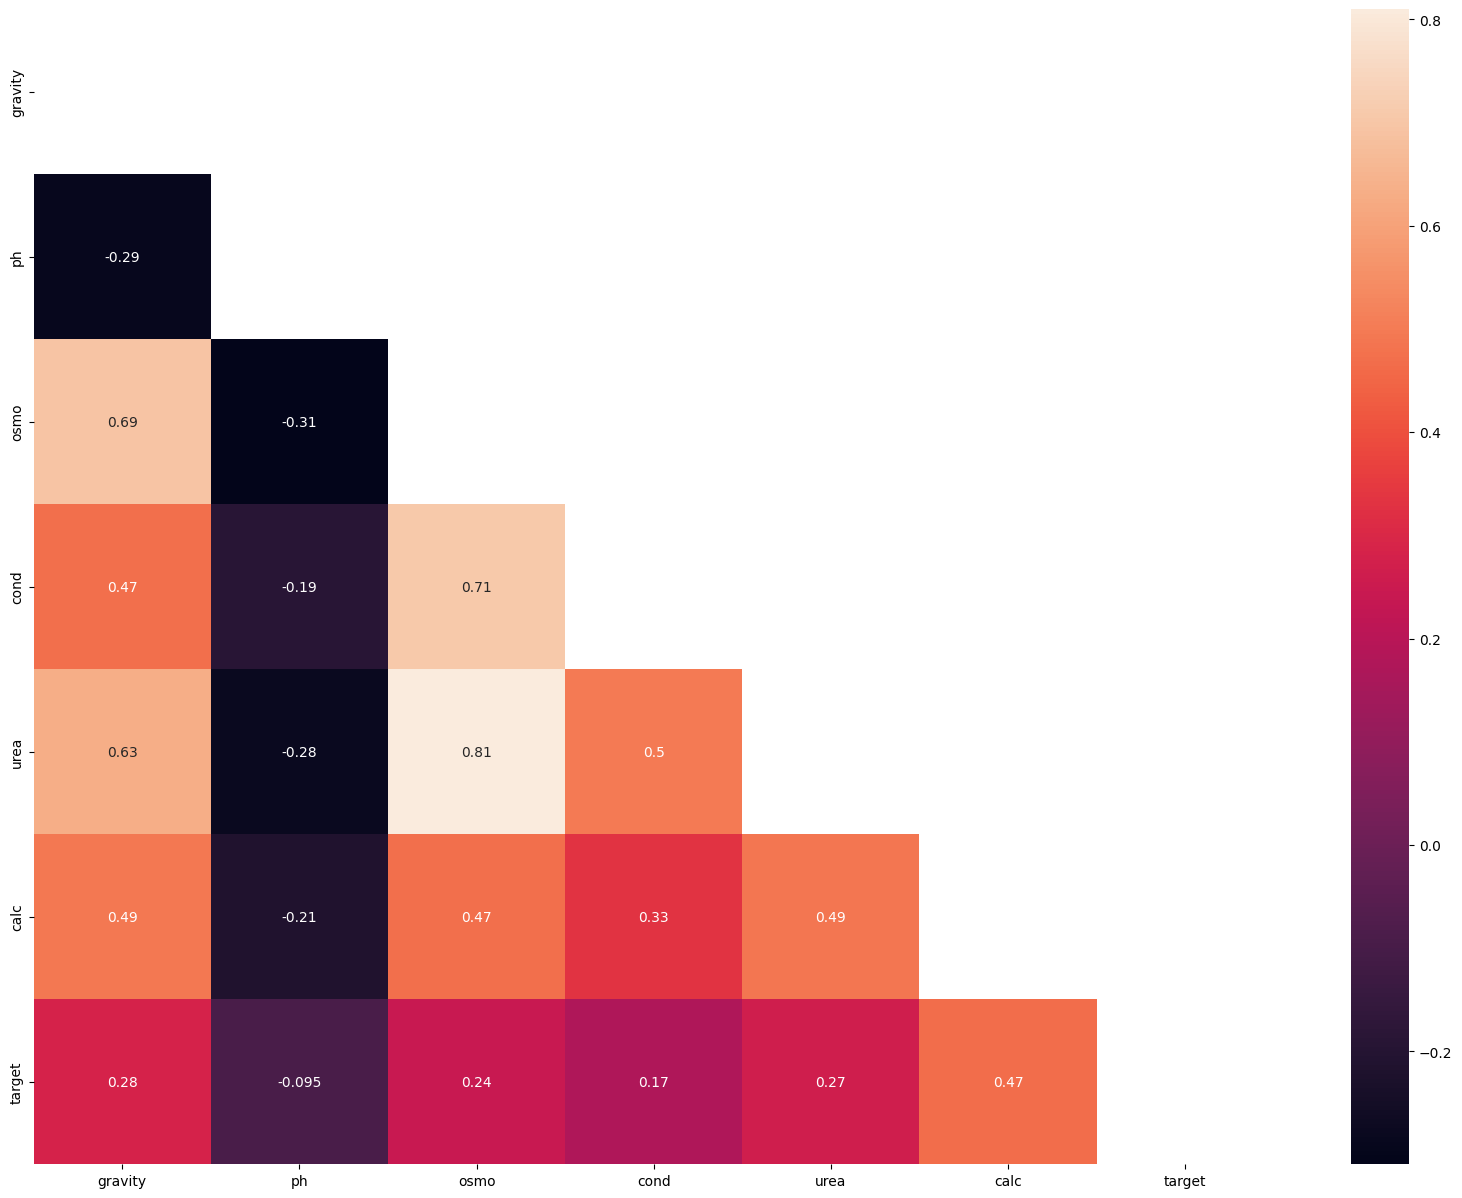

In [12]:
# Plotting the correlations
pearson = data.corr()

plt.figure(figsize=(20,15))
sns.heatmap(pearson, annot=True, mask=np.triu(pearson))
plt.show()

As we would expect, `ph` has the lowest correlation to `target`. `calc` is the variable most correlated to `target`.

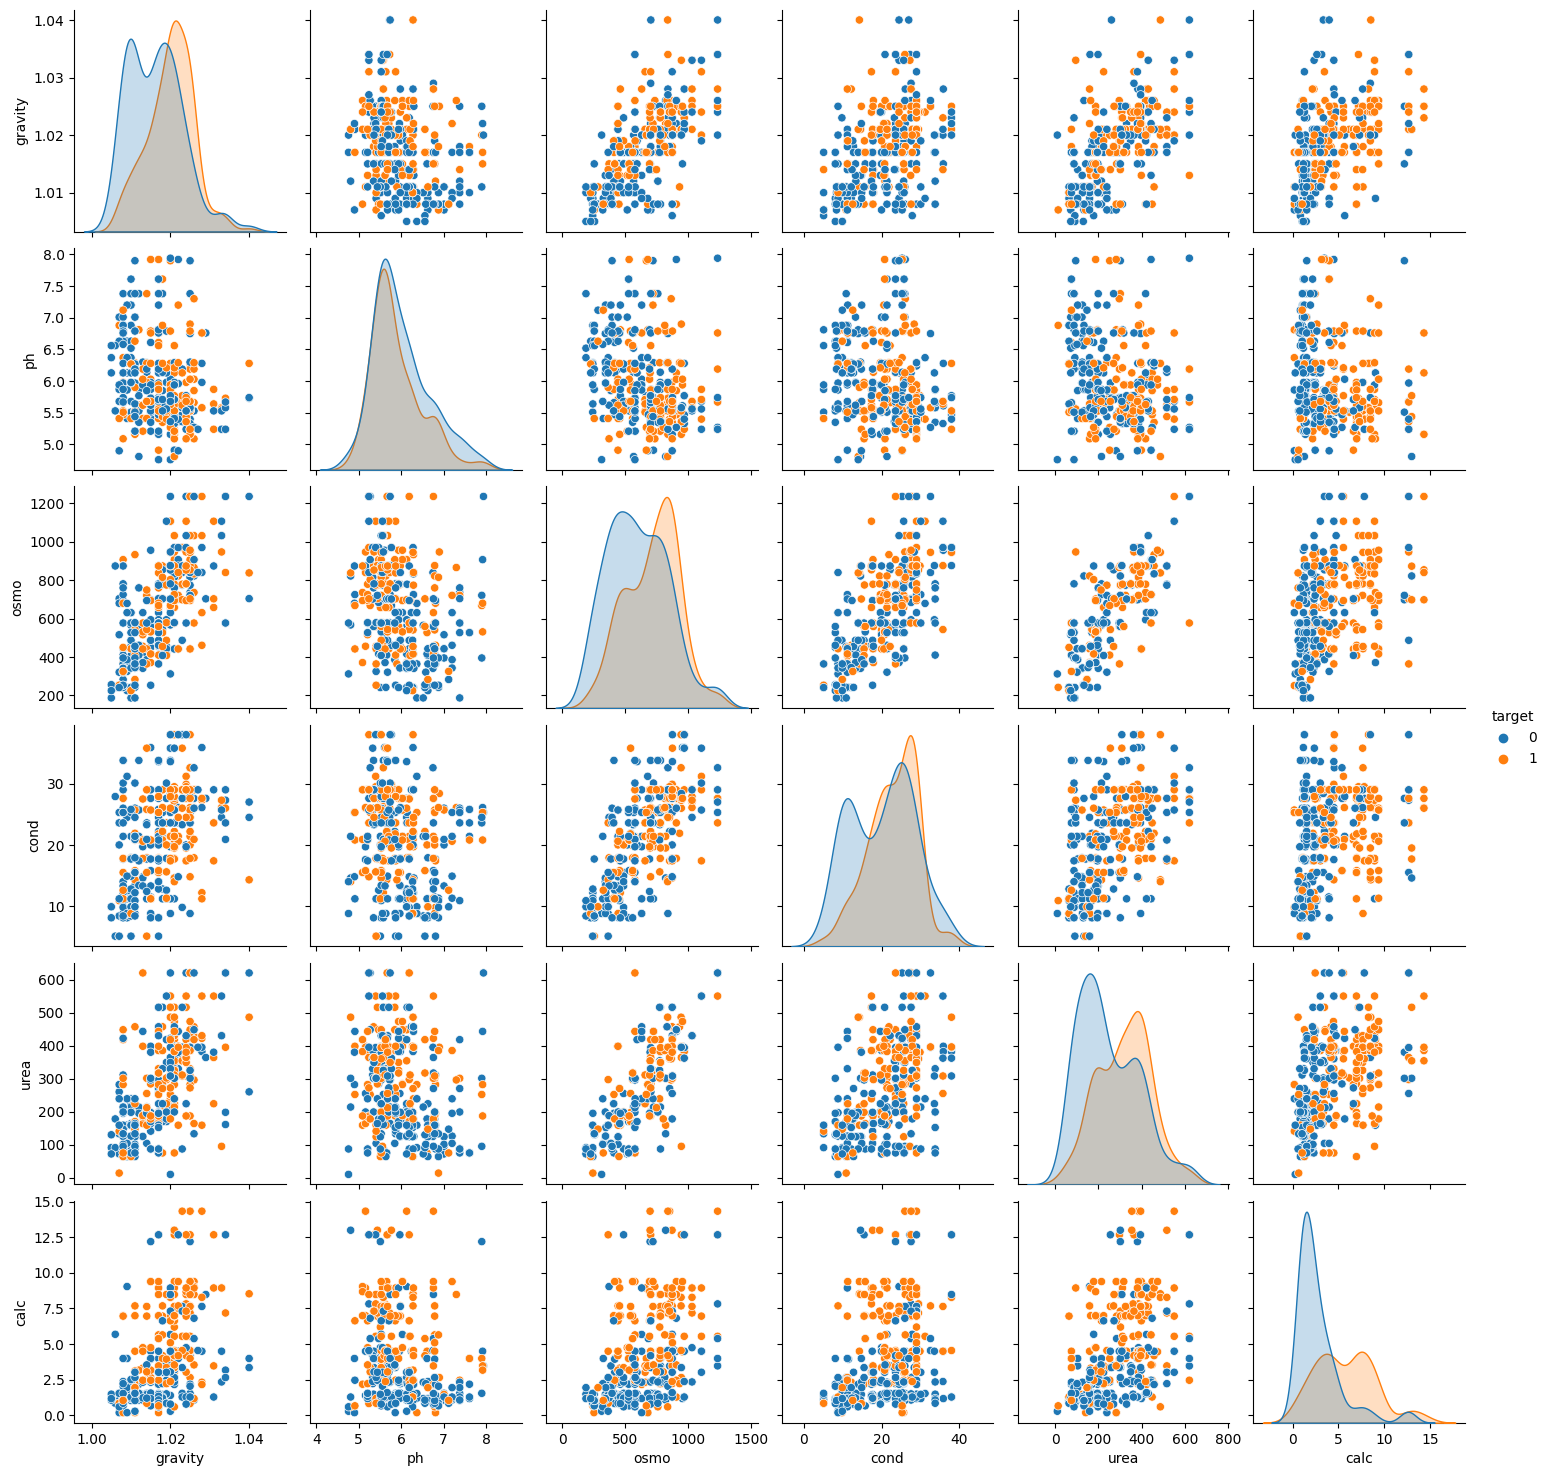

In [13]:
sns.pairplot(data=data, hue="target",
             vars=["gravity", "ph", "osmo", "cond", "urea", "calc"])
plt.show()

## Feature Engineering

### Combining Features

Let's try creating some new features. I'm not a biologist, so I don't know what would make sense here (or better yet, if it would make sense to combine the features). But we've seen that `ph` is not the best variable to predict the target. So let's combine it with some of the other features.

In [14]:
# Create a copy of the dataset
data_copy = data.copy()

In [15]:
for i in ["gravity", "osmo", "cond", "urea", "calc"]:
    print(f"ph / {i}:")
    data_copy["placeholder"] = data_copy["ph"] / data_copy[i]
    display(data_copy[["placeholder", "target"]].corr())

ph / gravity:


,placeholder,target
placeholder,1.000000,-0.110475
target,-0.110475,1.000000


ph / osmo:


,placeholder,target
placeholder,1.000000,-0.252036
target,-0.252036,1.000000


ph / cond:


,placeholder,target
placeholder,1.000000,-0.217256
target,-0.217256,1.000000


ph / urea:


,placeholder,target
placeholder,1.000000,-0.150496
target,-0.150496,1.000000


ph / calc:


,placeholder,target
placeholder,1.000000,-0.185012
target,-0.185012,1.000000


Let's select some of them to include in our dataset:

In [16]:
data_copy.drop(["placeholder"], axis=1, inplace=True)
data_copy["ph_osmo"] = data_copy["ph"] / data_copy["osmo"]
data_copy["ph_cond"] = data_copy["ph"] / data_copy["cond"]
data_copy["ph_calc"] = data_copy["ph"] / data_copy["calc"]

In [17]:
data_copy.head()

,gravity,ph,osmo,cond,urea,calc,target,ph_osmo,ph_cond,ph_calc
0,1.013,6.19,443,14.8,124,1.45,0,0.013973,0.418243,4.268966
1,1.025,5.40,703,23.6,394,4.18,0,0.007681,0.228814,1.291866
2,1.009,6.13,371,24.5,159,9.04,0,0.016523,0.250204,0.678097
3,1.021,4.91,442,20.8,398,6.63,1,0.011109,0.236058,0.740573
4,1.021,5.53,874,17.8,385,2.21,1,0.006327,0.310674,2.502262


### Cluster Analysis

Since we don't have many features, what about we try to create a cluster analysis?

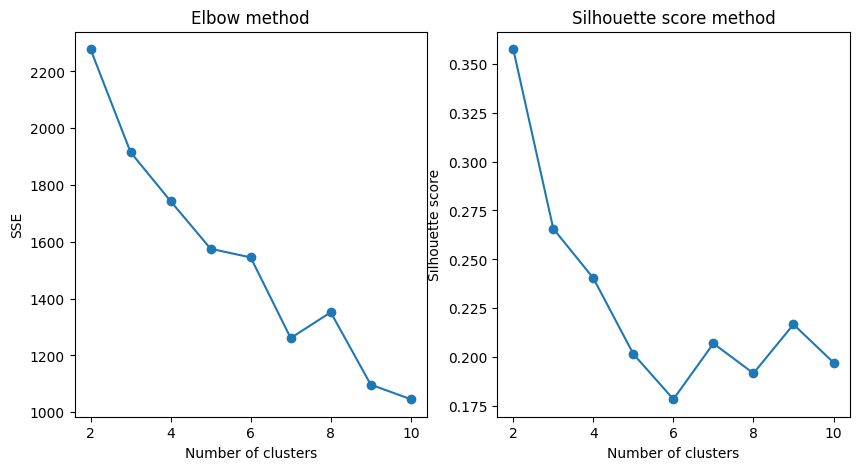

In [18]:
# Select the columns you want to cluster on
X = data_copy.drop(["target"], axis=1)

# Standardize the data (optional but recommended for KMeans)
X = (X - X.mean()) / X.std()

# Determine the optimal number of clusters using the Elbow method
sse = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(2, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score method')

plt.show()

In [19]:
# Choose the optimal number of clusters based on the Elbow method
optimal_k = 3  # change this to the elbow point you see in the plot

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, n_init="auto")
kmeans.fit(X)

# Add the cluster labels to your DataFrame
data_copy['cluster'] = kmeans.labels_

# Print the results
data_copy.head()

,gravity,ph,osmo,cond,urea,calc,target,ph_osmo,ph_cond,ph_calc,cluster
0,1.013,6.19,443,14.8,124,1.45,0,0.013973,0.418243,4.268966,1
1,1.025,5.40,703,23.6,394,4.18,0,0.007681,0.228814,1.291866,0
2,1.009,6.13,371,24.5,159,9.04,0,0.016523,0.250204,0.678097,1
3,1.021,4.91,442,20.8,398,6.63,1,0.011109,0.236058,0.740573,0
4,1.021,5.53,874,17.8,385,2.21,1,0.006327,0.310674,2.502262,0


### Preparing the Data

In [20]:
one_hot_encoding = pd.get_dummies(data_copy["cluster"], drop_first=True, prefix="cluster")
data_copy = pd.concat([data_copy, one_hot_encoding], axis=1)
data_copy.drop(["cluster"], axis=1, inplace=True)

In [21]:
X, y = data_copy.drop(["target"], axis=1), data_copy["target"]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

While we're at it, let's prepare also the final test data:

In [22]:
test_data = pd.read_csv("./data/playground-series-s3e12/test.csv")

In [23]:
test_data["ph_osmo"] = test_data["ph"] / test_data["osmo"]
test_data["ph_cond"] = test_data["ph"] / test_data["cond"]
test_data["ph_calc"] = test_data["ph"] / test_data["calc"]

In [24]:
kmeans.fit(test_data)
test_data['cluster'] = kmeans.labels_

In [25]:
one_hot_encoding = pd.get_dummies(test_data["cluster"], drop_first=True, prefix="cluster")
test_data = pd.concat([test_data, one_hot_encoding], axis=1)
test_data.drop(["cluster"], axis=1, inplace=True)

In [26]:
test_data.head()

,id,gravity,ph,osmo,cond,urea,calc,ph_osmo,ph_cond,ph_calc,cluster_1,cluster_2
0,414,1.017,5.24,345,11.5,152,1.16,0.015188,0.455652,4.517241,False,True
1,415,1.020,5.68,874,29.0,385,3.46,0.006499,0.195862,1.641618,True,False
2,416,1.024,5.36,698,19.5,354,13.00,0.007679,0.274872,0.412308,False,False
3,417,1.020,5.33,668,25.3,252,3.46,0.007979,0.210672,1.540462,False,False
4,418,1.011,5.87,567,29.0,457,2.36,0.010353,0.202414,2.487288,False,False


In [196]:
test_data_scaled = scaler.fit_transform(test_data.drop(["id"], axis=1))

In [197]:
test_data_scaled

array([[-0.20280456, -1.15389851, -1.31346969, ...,  0.59183525,
        -0.78963879,  1.36930639],
       [ 0.25474905, -0.42787688,  0.92868895, ..., -0.36833341,
         1.26640183, -0.73029674],
       [ 0.86482054, -0.95589261,  0.18271557, ..., -0.77879952,
        -0.78963879, -0.73029674],
       ...,
       [ 1.93244564, -0.42787688,  0.92868895, ..., -0.49407494,
         1.26640183, -0.73029674],
       [ 0.10223118, -0.7743872 , -0.47424963, ...,  0.19720776,
        -0.78963879,  1.36930639],
       [-0.20280456,  0.41364819,  0.18271557, ..., -0.33096254,
        -0.78963879, -0.73029674]])

## Fitting the Data

### Stochastic Gradient Descent

In [213]:
# sgd = SGDClassifier(loss="log_loss", random_state=42)
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd

SGDClassifier(loss='log_loss', random_state=42)

#### Training Set

In [214]:
sgd.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [215]:
cv_scores = cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")
cv_scores

array([0.52252252, 0.58181818, 0.62727273])

In [216]:
y_train_pred = cross_val_predict(sgd, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.5172413793103449.
Recall: 0.6164383561643836.
F1 Score: 0.5624999999999999.


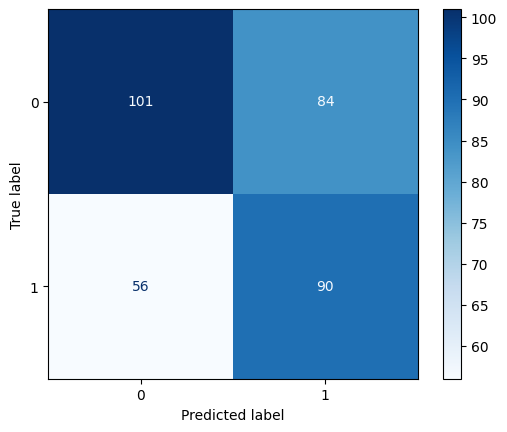

In [217]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

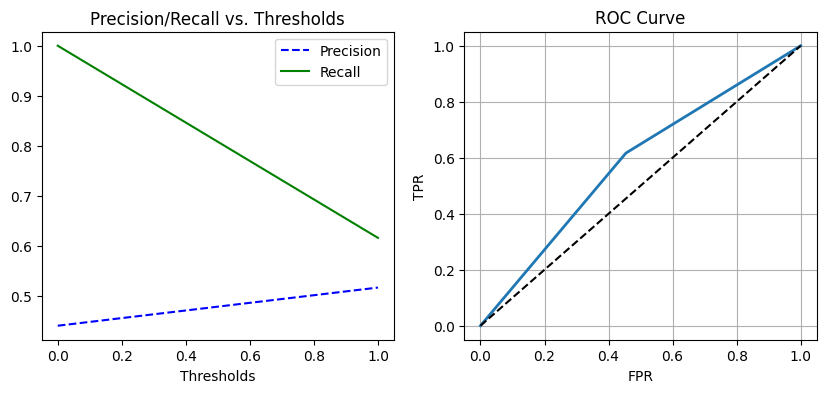

In [218]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [219]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.5811921510551648.


#### Test Set

In [220]:
y_pred = sgd.predict(X_test)

In [221]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.723404255319149.
Recall: 0.8947368421052632.
F1 Score: 0.8.


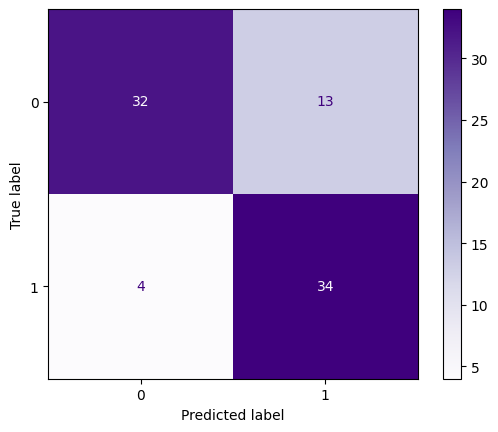

In [222]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [223]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7951807228915663.


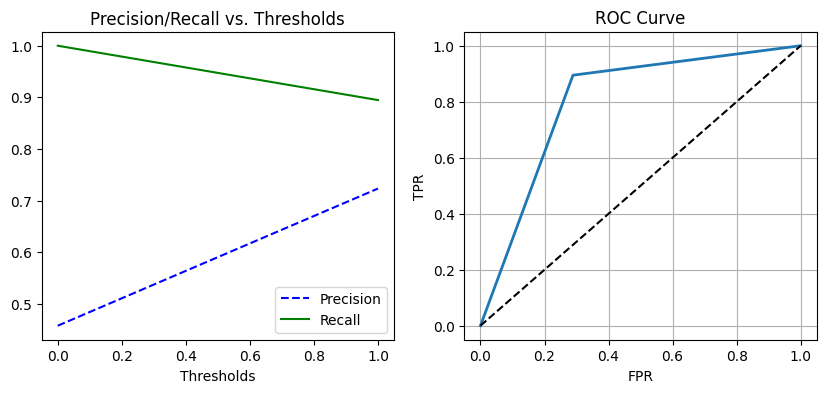

In [224]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [225]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.8029239766081873.


In [226]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "SGD",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## CatBoost Classifier

In [43]:
cb_clf = cb.CatBoostClassifier(random_state=42)
cb_clf

In [44]:
cb_clf.fit(X_train, y_train, verbose=250)

Learning rate set to 0.006425
0:	learn: 0.6910709	total: 783ms	remaining: 13m 2s
250:	learn: 0.4525727	total: 1.41s	remaining: 4.22s
500:	learn: 0.3707328	total: 2.02s	remaining: 2.01s
750:	learn: 0.3156108	total: 2.65s	remaining: 881ms
999:	learn: 0.2681676	total: 3.26s	remaining: 0us


In [45]:
cv_scores = cross_val_score(cb_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)

Learning rate set to 0.005397
0:	learn: 0.6905634	total: 4.75ms	remaining: 4.75s
1:	learn: 0.6883111	total: 16.4ms	remaining: 8.19s
2:	learn: 0.6862464	total: 23.2ms	remaining: 7.71s
3:	learn: 0.6842976	total: 27ms	remaining: 6.72s
4:	learn: 0.6823848	total: 30.9ms	remaining: 6.15s
5:	learn: 0.6803708	total: 34ms	remaining: 5.64s
6:	learn: 0.6790078	total: 36.8ms	remaining: 5.21s
7:	learn: 0.6773628	total: 39.1ms	remaining: 4.85s
8:	learn: 0.6756190	total: 41.5ms	remaining: 4.58s
9:	learn: 0.6737694	total: 43.7ms	remaining: 4.33s
10:	learn: 0.6719362	total: 46.1ms	remaining: 4.14s
11:	learn: 0.6701614	total: 48.4ms	remaining: 3.98s
12:	learn: 0.6679943	total: 50.4ms	remaining: 3.83s
13:	learn: 0.6655434	total: 52.6ms	remaining: 3.71s
14:	learn: 0.6639141	total: 54.6ms	remaining: 3.58s
15:	learn: 0.6626352	total: 56.7ms	remaining: 3.49s
16:	learn: 0.6608034	total: 58.8ms	remaining: 3.4s
17:	learn: 0.6588594	total: 60.8ms	remaining: 3.32s
18:	learn: 0.6572003	total: 62.8ms	remaining: 3.2

224:	learn: 0.4623461	total: 523ms	remaining: 1.8s
225:	learn: 0.4617694	total: 526ms	remaining: 1.8s
226:	learn: 0.4614368	total: 528ms	remaining: 1.8s
227:	learn: 0.4610509	total: 531ms	remaining: 1.8s
228:	learn: 0.4606563	total: 533ms	remaining: 1.79s
229:	learn: 0.4600597	total: 536ms	remaining: 1.79s
230:	learn: 0.4594284	total: 538ms	remaining: 1.79s
231:	learn: 0.4591064	total: 541ms	remaining: 1.79s
232:	learn: 0.4583016	total: 543ms	remaining: 1.79s
233:	learn: 0.4576604	total: 546ms	remaining: 1.79s
234:	learn: 0.4570389	total: 548ms	remaining: 1.78s
235:	learn: 0.4563437	total: 551ms	remaining: 1.78s
236:	learn: 0.4556837	total: 553ms	remaining: 1.78s
237:	learn: 0.4553071	total: 555ms	remaining: 1.78s
238:	learn: 0.4549565	total: 557ms	remaining: 1.77s
239:	learn: 0.4545357	total: 559ms	remaining: 1.77s
240:	learn: 0.4540460	total: 561ms	remaining: 1.77s
241:	learn: 0.4536714	total: 563ms	remaining: 1.76s
242:	learn: 0.4528955	total: 565ms	remaining: 1.76s
243:	learn: 0.45

408:	learn: 0.3850461	total: 908ms	remaining: 1.31s
409:	learn: 0.3847504	total: 910ms	remaining: 1.31s
410:	learn: 0.3844097	total: 913ms	remaining: 1.31s
411:	learn: 0.3842108	total: 915ms	remaining: 1.31s
412:	learn: 0.3838075	total: 918ms	remaining: 1.3s
413:	learn: 0.3836682	total: 920ms	remaining: 1.3s
414:	learn: 0.3831794	total: 922ms	remaining: 1.3s
415:	learn: 0.3829133	total: 925ms	remaining: 1.3s
416:	learn: 0.3826897	total: 929ms	remaining: 1.3s
417:	learn: 0.3824193	total: 931ms	remaining: 1.3s
418:	learn: 0.3820031	total: 934ms	remaining: 1.29s
419:	learn: 0.3818579	total: 936ms	remaining: 1.29s
420:	learn: 0.3817144	total: 938ms	remaining: 1.29s
421:	learn: 0.3812777	total: 940ms	remaining: 1.29s
422:	learn: 0.3810321	total: 942ms	remaining: 1.28s
423:	learn: 0.3807178	total: 944ms	remaining: 1.28s
424:	learn: 0.3803966	total: 946ms	remaining: 1.28s
425:	learn: 0.3798615	total: 948ms	remaining: 1.28s
426:	learn: 0.3795513	total: 952ms	remaining: 1.28s
427:	learn: 0.3791

633:	learn: 0.3240198	total: 1.49s	remaining: 861ms
634:	learn: 0.3237932	total: 1.49s	remaining: 859ms
635:	learn: 0.3237389	total: 1.5s	remaining: 856ms
636:	learn: 0.3235401	total: 1.5s	remaining: 855ms
637:	learn: 0.3233564	total: 1.5s	remaining: 853ms
638:	learn: 0.3232429	total: 1.5s	remaining: 851ms
639:	learn: 0.3230638	total: 1.51s	remaining: 848ms
640:	learn: 0.3227374	total: 1.51s	remaining: 846ms
641:	learn: 0.3224655	total: 1.52s	remaining: 846ms
642:	learn: 0.3221557	total: 1.52s	remaining: 844ms
643:	learn: 0.3217973	total: 1.52s	remaining: 841ms
644:	learn: 0.3217556	total: 1.52s	remaining: 839ms
645:	learn: 0.3215966	total: 1.52s	remaining: 836ms
646:	learn: 0.3213088	total: 1.53s	remaining: 834ms
647:	learn: 0.3210430	total: 1.53s	remaining: 832ms
648:	learn: 0.3208213	total: 1.53s	remaining: 830ms
649:	learn: 0.3206559	total: 1.54s	remaining: 828ms
650:	learn: 0.3204427	total: 1.54s	remaining: 825ms
651:	learn: 0.3202185	total: 1.54s	remaining: 822ms
652:	learn: 0.31

881:	learn: 0.2708649	total: 2.06s	remaining: 276ms
882:	learn: 0.2708015	total: 2.07s	remaining: 274ms
883:	learn: 0.2705601	total: 2.07s	remaining: 272ms
884:	learn: 0.2703845	total: 2.07s	remaining: 269ms
885:	learn: 0.2701370	total: 2.08s	remaining: 267ms
886:	learn: 0.2700355	total: 2.08s	remaining: 265ms
887:	learn: 0.2699280	total: 2.08s	remaining: 262ms
888:	learn: 0.2697952	total: 2.08s	remaining: 260ms
889:	learn: 0.2696448	total: 2.08s	remaining: 258ms
890:	learn: 0.2694993	total: 2.09s	remaining: 256ms
891:	learn: 0.2693810	total: 2.09s	remaining: 253ms
892:	learn: 0.2692467	total: 2.09s	remaining: 251ms
893:	learn: 0.2689355	total: 2.1s	remaining: 248ms
894:	learn: 0.2688416	total: 2.1s	remaining: 246ms
895:	learn: 0.2687131	total: 2.1s	remaining: 244ms
896:	learn: 0.2684752	total: 2.1s	remaining: 241ms
897:	learn: 0.2682913	total: 2.1s	remaining: 239ms
898:	learn: 0.2680837	total: 2.11s	remaining: 237ms
899:	learn: 0.2679303	total: 2.11s	remaining: 234ms
900:	learn: 0.267

73:	learn: 0.5679188	total: 192ms	remaining: 2.4s
74:	learn: 0.5667565	total: 194ms	remaining: 2.39s
75:	learn: 0.5655896	total: 197ms	remaining: 2.39s
76:	learn: 0.5641840	total: 199ms	remaining: 2.38s
77:	learn: 0.5631307	total: 201ms	remaining: 2.38s
78:	learn: 0.5618154	total: 203ms	remaining: 2.37s
79:	learn: 0.5600595	total: 205ms	remaining: 2.36s
80:	learn: 0.5588546	total: 208ms	remaining: 2.36s
81:	learn: 0.5576388	total: 210ms	remaining: 2.35s
82:	learn: 0.5563709	total: 213ms	remaining: 2.35s
83:	learn: 0.5552500	total: 216ms	remaining: 2.35s
84:	learn: 0.5543752	total: 218ms	remaining: 2.34s
85:	learn: 0.5535256	total: 220ms	remaining: 2.33s
86:	learn: 0.5529191	total: 221ms	remaining: 2.32s
87:	learn: 0.5519031	total: 223ms	remaining: 2.31s
88:	learn: 0.5509982	total: 225ms	remaining: 2.3s
89:	learn: 0.5499522	total: 227ms	remaining: 2.29s
90:	learn: 0.5488323	total: 229ms	remaining: 2.29s
91:	learn: 0.5475583	total: 231ms	remaining: 2.28s
92:	learn: 0.5464276	total: 233ms

262:	learn: 0.4228759	total: 583ms	remaining: 1.63s
263:	learn: 0.4224348	total: 586ms	remaining: 1.63s
264:	learn: 0.4217909	total: 588ms	remaining: 1.63s
265:	learn: 0.4213540	total: 590ms	remaining: 1.63s
266:	learn: 0.4209124	total: 597ms	remaining: 1.64s
267:	learn: 0.4204637	total: 599ms	remaining: 1.64s
268:	learn: 0.4201582	total: 601ms	remaining: 1.63s
269:	learn: 0.4198532	total: 605ms	remaining: 1.64s
270:	learn: 0.4191358	total: 607ms	remaining: 1.63s
271:	learn: 0.4187155	total: 612ms	remaining: 1.64s
272:	learn: 0.4181888	total: 614ms	remaining: 1.64s
273:	learn: 0.4176457	total: 616ms	remaining: 1.63s
274:	learn: 0.4171835	total: 618ms	remaining: 1.63s
275:	learn: 0.4167283	total: 620ms	remaining: 1.63s
276:	learn: 0.4162703	total: 622ms	remaining: 1.62s
277:	learn: 0.4157749	total: 626ms	remaining: 1.63s
278:	learn: 0.4152100	total: 629ms	remaining: 1.62s
279:	learn: 0.4148261	total: 631ms	remaining: 1.62s
280:	learn: 0.4142325	total: 633ms	remaining: 1.62s
281:	learn: 

445:	learn: 0.3522239	total: 969ms	remaining: 1.2s
446:	learn: 0.3520511	total: 972ms	remaining: 1.2s
447:	learn: 0.3518850	total: 974ms	remaining: 1.2s
448:	learn: 0.3515601	total: 976ms	remaining: 1.2s
449:	learn: 0.3513475	total: 978ms	remaining: 1.2s
450:	learn: 0.3512705	total: 981ms	remaining: 1.19s
451:	learn: 0.3510152	total: 983ms	remaining: 1.19s
452:	learn: 0.3506788	total: 985ms	remaining: 1.19s
453:	learn: 0.3502828	total: 988ms	remaining: 1.19s
454:	learn: 0.3499640	total: 990ms	remaining: 1.19s
455:	learn: 0.3497034	total: 992ms	remaining: 1.18s
456:	learn: 0.3493856	total: 994ms	remaining: 1.18s
457:	learn: 0.3490659	total: 996ms	remaining: 1.18s
458:	learn: 0.3489242	total: 998ms	remaining: 1.18s
459:	learn: 0.3488032	total: 1000ms	remaining: 1.17s
460:	learn: 0.3486709	total: 1s	remaining: 1.17s
461:	learn: 0.3484082	total: 1s	remaining: 1.17s
462:	learn: 0.3480751	total: 1s	remaining: 1.17s
463:	learn: 0.3477977	total: 1.01s	remaining: 1.16s
464:	learn: 0.3475396	tot

640:	learn: 0.3026927	total: 1.36s	remaining: 760ms
641:	learn: 0.3025582	total: 1.36s	remaining: 758ms
642:	learn: 0.3023390	total: 1.36s	remaining: 756ms
643:	learn: 0.3020437	total: 1.36s	remaining: 754ms
644:	learn: 0.3017511	total: 1.37s	remaining: 752ms
645:	learn: 0.3014898	total: 1.37s	remaining: 750ms
646:	learn: 0.3012217	total: 1.37s	remaining: 748ms
647:	learn: 0.3010822	total: 1.37s	remaining: 746ms
648:	learn: 0.3009189	total: 1.38s	remaining: 745ms
649:	learn: 0.3006495	total: 1.38s	remaining: 742ms
650:	learn: 0.3002425	total: 1.38s	remaining: 740ms
651:	learn: 0.2998843	total: 1.38s	remaining: 738ms
652:	learn: 0.2994275	total: 1.39s	remaining: 736ms
653:	learn: 0.2991631	total: 1.39s	remaining: 734ms
654:	learn: 0.2989945	total: 1.39s	remaining: 732ms
655:	learn: 0.2988180	total: 1.39s	remaining: 729ms
656:	learn: 0.2985596	total: 1.39s	remaining: 727ms
657:	learn: 0.2982629	total: 1.39s	remaining: 725ms
658:	learn: 0.2979362	total: 1.4s	remaining: 723ms
659:	learn: 0

803:	learn: 0.2683262	total: 1.74s	remaining: 424ms
804:	learn: 0.2681507	total: 1.74s	remaining: 422ms
805:	learn: 0.2680640	total: 1.74s	remaining: 420ms
806:	learn: 0.2679191	total: 1.75s	remaining: 418ms
807:	learn: 0.2679052	total: 1.75s	remaining: 415ms
808:	learn: 0.2678120	total: 1.75s	remaining: 413ms
809:	learn: 0.2676025	total: 1.75s	remaining: 411ms
810:	learn: 0.2673628	total: 1.75s	remaining: 409ms
811:	learn: 0.2670231	total: 1.76s	remaining: 407ms
812:	learn: 0.2667489	total: 1.76s	remaining: 405ms
813:	learn: 0.2664525	total: 1.76s	remaining: 403ms
814:	learn: 0.2662514	total: 1.76s	remaining: 400ms
815:	learn: 0.2661648	total: 1.77s	remaining: 398ms
816:	learn: 0.2660011	total: 1.77s	remaining: 396ms
817:	learn: 0.2658277	total: 1.77s	remaining: 394ms
818:	learn: 0.2656469	total: 1.77s	remaining: 392ms
819:	learn: 0.2655322	total: 1.77s	remaining: 389ms
820:	learn: 0.2653830	total: 1.78s	remaining: 387ms
821:	learn: 0.2651873	total: 1.78s	remaining: 385ms
822:	learn: 

983:	learn: 0.2345173	total: 2.14s	remaining: 34.7ms
984:	learn: 0.2343022	total: 2.14s	remaining: 32.6ms
985:	learn: 0.2340941	total: 2.14s	remaining: 30.4ms
986:	learn: 0.2337536	total: 2.15s	remaining: 28.3ms
987:	learn: 0.2334880	total: 2.15s	remaining: 26.1ms
988:	learn: 0.2332335	total: 2.15s	remaining: 23.9ms
989:	learn: 0.2330521	total: 2.15s	remaining: 21.8ms
990:	learn: 0.2328788	total: 2.16s	remaining: 19.6ms
991:	learn: 0.2326207	total: 2.16s	remaining: 17.4ms
992:	learn: 0.2323957	total: 2.16s	remaining: 15.3ms
993:	learn: 0.2321773	total: 2.17s	remaining: 13.1ms
994:	learn: 0.2319448	total: 2.17s	remaining: 10.9ms
995:	learn: 0.2317035	total: 2.17s	remaining: 8.72ms
996:	learn: 0.2314778	total: 2.17s	remaining: 6.54ms
997:	learn: 0.2313612	total: 2.17s	remaining: 4.36ms
998:	learn: 0.2311002	total: 2.18s	remaining: 2.18ms
999:	learn: 0.2308821	total: 2.18s	remaining: 0us
Learning rate set to 0.005407
0:	learn: 0.6910418	total: 6.73ms	remaining: 6.72s
1:	learn: 0.6889850	t

223:	learn: 0.4668347	total: 542ms	remaining: 1.88s
224:	learn: 0.4663548	total: 545ms	remaining: 1.88s
225:	learn: 0.4657149	total: 547ms	remaining: 1.87s
226:	learn: 0.4650524	total: 549ms	remaining: 1.87s
227:	learn: 0.4645409	total: 552ms	remaining: 1.87s
228:	learn: 0.4639105	total: 554ms	remaining: 1.86s
229:	learn: 0.4633588	total: 556ms	remaining: 1.86s
230:	learn: 0.4628302	total: 558ms	remaining: 1.86s
231:	learn: 0.4621619	total: 561ms	remaining: 1.86s
232:	learn: 0.4617315	total: 564ms	remaining: 1.85s
233:	learn: 0.4612484	total: 567ms	remaining: 1.86s
234:	learn: 0.4606726	total: 569ms	remaining: 1.85s
235:	learn: 0.4601568	total: 572ms	remaining: 1.85s
236:	learn: 0.4597095	total: 574ms	remaining: 1.85s
237:	learn: 0.4593529	total: 577ms	remaining: 1.84s
238:	learn: 0.4586641	total: 579ms	remaining: 1.84s
239:	learn: 0.4581836	total: 581ms	remaining: 1.84s
240:	learn: 0.4576002	total: 583ms	remaining: 1.84s
241:	learn: 0.4570775	total: 585ms	remaining: 1.83s
242:	learn: 

405:	learn: 0.3880973	total: 921ms	remaining: 1.35s
406:	learn: 0.3877865	total: 924ms	remaining: 1.34s
407:	learn: 0.3874156	total: 926ms	remaining: 1.34s
408:	learn: 0.3871629	total: 928ms	remaining: 1.34s
409:	learn: 0.3867885	total: 931ms	remaining: 1.34s
410:	learn: 0.3863787	total: 933ms	remaining: 1.34s
411:	learn: 0.3861551	total: 935ms	remaining: 1.33s
412:	learn: 0.3857542	total: 938ms	remaining: 1.33s
413:	learn: 0.3854743	total: 940ms	remaining: 1.33s
414:	learn: 0.3852423	total: 943ms	remaining: 1.33s
415:	learn: 0.3847213	total: 945ms	remaining: 1.33s
416:	learn: 0.3843169	total: 947ms	remaining: 1.32s
417:	learn: 0.3840523	total: 949ms	remaining: 1.32s
418:	learn: 0.3837109	total: 951ms	remaining: 1.32s
419:	learn: 0.3833621	total: 953ms	remaining: 1.31s
420:	learn: 0.3829830	total: 954ms	remaining: 1.31s
421:	learn: 0.3826958	total: 956ms	remaining: 1.31s
422:	learn: 0.3822565	total: 958ms	remaining: 1.31s
423:	learn: 0.3820612	total: 960ms	remaining: 1.3s
424:	learn: 0

603:	learn: 0.3313832	total: 1.31s	remaining: 858ms
604:	learn: 0.3312471	total: 1.31s	remaining: 857ms
605:	learn: 0.3310547	total: 1.31s	remaining: 855ms
606:	learn: 0.3308583	total: 1.32s	remaining: 853ms
607:	learn: 0.3306276	total: 1.32s	remaining: 851ms
608:	learn: 0.3305148	total: 1.32s	remaining: 849ms
609:	learn: 0.3302754	total: 1.32s	remaining: 847ms
610:	learn: 0.3301363	total: 1.33s	remaining: 845ms
611:	learn: 0.3299414	total: 1.33s	remaining: 843ms
612:	learn: 0.3296265	total: 1.33s	remaining: 841ms
613:	learn: 0.3293997	total: 1.33s	remaining: 838ms
614:	learn: 0.3291541	total: 1.33s	remaining: 836ms
615:	learn: 0.3288225	total: 1.34s	remaining: 834ms
616:	learn: 0.3286201	total: 1.34s	remaining: 831ms
617:	learn: 0.3284507	total: 1.34s	remaining: 829ms
618:	learn: 0.3281736	total: 1.34s	remaining: 827ms
619:	learn: 0.3278964	total: 1.34s	remaining: 825ms
620:	learn: 0.3277709	total: 1.35s	remaining: 822ms
621:	learn: 0.3276380	total: 1.35s	remaining: 820ms
622:	learn: 

782:	learn: 0.2920372	total: 1.71s	remaining: 474ms
783:	learn: 0.2917021	total: 1.71s	remaining: 472ms
784:	learn: 0.2914564	total: 1.72s	remaining: 470ms
785:	learn: 0.2913486	total: 1.72s	remaining: 468ms
786:	learn: 0.2911825	total: 1.72s	remaining: 465ms
787:	learn: 0.2911509	total: 1.72s	remaining: 463ms
788:	learn: 0.2909459	total: 1.72s	remaining: 461ms
789:	learn: 0.2907947	total: 1.73s	remaining: 459ms
790:	learn: 0.2905147	total: 1.73s	remaining: 457ms
791:	learn: 0.2903557	total: 1.73s	remaining: 455ms
792:	learn: 0.2901746	total: 1.73s	remaining: 453ms
793:	learn: 0.2899433	total: 1.74s	remaining: 451ms
794:	learn: 0.2898198	total: 1.74s	remaining: 448ms
795:	learn: 0.2895663	total: 1.74s	remaining: 446ms
796:	learn: 0.2894088	total: 1.74s	remaining: 444ms
797:	learn: 0.2892455	total: 1.74s	remaining: 442ms
798:	learn: 0.2889164	total: 1.75s	remaining: 439ms
799:	learn: 0.2886464	total: 1.75s	remaining: 437ms
800:	learn: 0.2885521	total: 1.75s	remaining: 435ms
801:	learn: 

981:	learn: 0.2528593	total: 2.1s	remaining: 38.5ms
982:	learn: 0.2526638	total: 2.1s	remaining: 36.4ms
983:	learn: 0.2524805	total: 2.1s	remaining: 34.2ms
984:	learn: 0.2523128	total: 2.11s	remaining: 32.1ms
985:	learn: 0.2520639	total: 2.11s	remaining: 29.9ms
986:	learn: 0.2519252	total: 2.11s	remaining: 27.8ms
987:	learn: 0.2517810	total: 2.11s	remaining: 25.7ms
988:	learn: 0.2515083	total: 2.12s	remaining: 23.5ms
989:	learn: 0.2512047	total: 2.12s	remaining: 21.4ms
990:	learn: 0.2510526	total: 2.12s	remaining: 19.3ms
991:	learn: 0.2508873	total: 2.12s	remaining: 17.1ms
992:	learn: 0.2507967	total: 2.12s	remaining: 15ms
993:	learn: 0.2507203	total: 2.13s	remaining: 12.8ms
994:	learn: 0.2506543	total: 2.13s	remaining: 10.7ms
995:	learn: 0.2504394	total: 2.13s	remaining: 8.56ms
996:	learn: 0.2501274	total: 2.13s	remaining: 6.42ms
997:	learn: 0.2499656	total: 2.13s	remaining: 4.28ms
998:	learn: 0.2497803	total: 2.14s	remaining: 2.14ms
999:	learn: 0.2495910	total: 2.14s	remaining: 0us


In [46]:
print(f"3-fold CV Scores: {cv_scores}.")

3-fold CV Scores: [0.72972973 0.71818182 0.71818182].


In [47]:
y_train_pred = cross_val_predict(cb_clf, X_train, y_train, cv=3)

Learning rate set to 0.005397
0:	learn: 0.6905634	total: 7.99ms	remaining: 7.99s
1:	learn: 0.6883111	total: 15.9ms	remaining: 7.93s
2:	learn: 0.6862464	total: 34.7ms	remaining: 11.5s
3:	learn: 0.6842976	total: 53.5ms	remaining: 13.3s
4:	learn: 0.6823848	total: 61ms	remaining: 12.1s
5:	learn: 0.6803708	total: 64.7ms	remaining: 10.7s
6:	learn: 0.6790078	total: 69.8ms	remaining: 9.9s
7:	learn: 0.6773628	total: 73.9ms	remaining: 9.16s
8:	learn: 0.6756190	total: 76.7ms	remaining: 8.44s
9:	learn: 0.6737694	total: 79.1ms	remaining: 7.83s
10:	learn: 0.6719362	total: 81.3ms	remaining: 7.31s
11:	learn: 0.6701614	total: 85.4ms	remaining: 7.03s
12:	learn: 0.6679943	total: 88.6ms	remaining: 6.73s
13:	learn: 0.6655434	total: 90.8ms	remaining: 6.39s
14:	learn: 0.6639141	total: 92.9ms	remaining: 6.1s
15:	learn: 0.6626352	total: 95.2ms	remaining: 5.85s
16:	learn: 0.6608034	total: 97.3ms	remaining: 5.63s
17:	learn: 0.6588594	total: 103ms	remaining: 5.6s
18:	learn: 0.6572003	total: 105ms	remaining: 5.42s

199:	learn: 0.4780911	total: 561ms	remaining: 2.24s
200:	learn: 0.4769538	total: 564ms	remaining: 2.24s
201:	learn: 0.4765253	total: 566ms	remaining: 2.24s
202:	learn: 0.4758059	total: 569ms	remaining: 2.23s
203:	learn: 0.4752273	total: 571ms	remaining: 2.23s
204:	learn: 0.4744170	total: 574ms	remaining: 2.22s
205:	learn: 0.4738461	total: 577ms	remaining: 2.22s
206:	learn: 0.4729816	total: 579ms	remaining: 2.22s
207:	learn: 0.4721756	total: 582ms	remaining: 2.22s
208:	learn: 0.4714518	total: 585ms	remaining: 2.21s
209:	learn: 0.4710513	total: 587ms	remaining: 2.21s
210:	learn: 0.4703952	total: 589ms	remaining: 2.2s
211:	learn: 0.4699384	total: 592ms	remaining: 2.2s
212:	learn: 0.4694389	total: 594ms	remaining: 2.19s
213:	learn: 0.4688715	total: 596ms	remaining: 2.19s
214:	learn: 0.4684548	total: 598ms	remaining: 2.18s
215:	learn: 0.4677787	total: 600ms	remaining: 2.18s
216:	learn: 0.4671657	total: 602ms	remaining: 2.17s
217:	learn: 0.4665779	total: 604ms	remaining: 2.17s
218:	learn: 0.

369:	learn: 0.3980036	total: 946ms	remaining: 1.61s
370:	learn: 0.3979176	total: 949ms	remaining: 1.61s
371:	learn: 0.3973157	total: 952ms	remaining: 1.61s
372:	learn: 0.3967733	total: 954ms	remaining: 1.6s
373:	learn: 0.3962835	total: 957ms	remaining: 1.6s
374:	learn: 0.3957334	total: 959ms	remaining: 1.6s
375:	learn: 0.3954516	total: 962ms	remaining: 1.6s
376:	learn: 0.3950478	total: 965ms	remaining: 1.59s
377:	learn: 0.3947136	total: 967ms	remaining: 1.59s
378:	learn: 0.3944713	total: 970ms	remaining: 1.59s
379:	learn: 0.3939860	total: 972ms	remaining: 1.58s
380:	learn: 0.3934790	total: 974ms	remaining: 1.58s
381:	learn: 0.3930794	total: 976ms	remaining: 1.58s
382:	learn: 0.3928853	total: 978ms	remaining: 1.57s
383:	learn: 0.3926856	total: 980ms	remaining: 1.57s
384:	learn: 0.3923610	total: 982ms	remaining: 1.57s
385:	learn: 0.3918998	total: 984ms	remaining: 1.56s
386:	learn: 0.3914544	total: 986ms	remaining: 1.56s
387:	learn: 0.3912660	total: 988ms	remaining: 1.56s
388:	learn: 0.39

548:	learn: 0.3449208	total: 1.33s	remaining: 1.09s
549:	learn: 0.3447321	total: 1.34s	remaining: 1.09s
550:	learn: 0.3443422	total: 1.34s	remaining: 1.09s
551:	learn: 0.3440852	total: 1.34s	remaining: 1.09s
552:	learn: 0.3436220	total: 1.34s	remaining: 1.09s
553:	learn: 0.3432066	total: 1.35s	remaining: 1.08s
554:	learn: 0.3430496	total: 1.35s	remaining: 1.08s
555:	learn: 0.3428893	total: 1.35s	remaining: 1.08s
556:	learn: 0.3425818	total: 1.35s	remaining: 1.08s
557:	learn: 0.3422600	total: 1.36s	remaining: 1.07s
558:	learn: 0.3421164	total: 1.36s	remaining: 1.07s
559:	learn: 0.3419144	total: 1.36s	remaining: 1.07s
560:	learn: 0.3418388	total: 1.36s	remaining: 1.07s
561:	learn: 0.3417140	total: 1.37s	remaining: 1.06s
562:	learn: 0.3415104	total: 1.37s	remaining: 1.06s
563:	learn: 0.3411474	total: 1.37s	remaining: 1.06s
564:	learn: 0.3408813	total: 1.37s	remaining: 1.06s
565:	learn: 0.3408241	total: 1.37s	remaining: 1.05s
566:	learn: 0.3405289	total: 1.38s	remaining: 1.05s
567:	learn: 

730:	learn: 0.3031875	total: 1.72s	remaining: 635ms
731:	learn: 0.3029559	total: 1.73s	remaining: 633ms
732:	learn: 0.3027525	total: 1.73s	remaining: 630ms
733:	learn: 0.3025251	total: 1.73s	remaining: 628ms
734:	learn: 0.3022147	total: 1.74s	remaining: 626ms
735:	learn: 0.3020635	total: 1.74s	remaining: 624ms
736:	learn: 0.3018719	total: 1.74s	remaining: 621ms
737:	learn: 0.3016557	total: 1.74s	remaining: 619ms
738:	learn: 0.3014281	total: 1.75s	remaining: 617ms
739:	learn: 0.3013249	total: 1.75s	remaining: 615ms
740:	learn: 0.3011021	total: 1.75s	remaining: 612ms
741:	learn: 0.3008640	total: 1.75s	remaining: 610ms
742:	learn: 0.3006580	total: 1.76s	remaining: 607ms
743:	learn: 0.3003963	total: 1.76s	remaining: 605ms
744:	learn: 0.3002288	total: 1.76s	remaining: 602ms
745:	learn: 0.2999120	total: 1.76s	remaining: 600ms
746:	learn: 0.2996615	total: 1.76s	remaining: 598ms
747:	learn: 0.2994957	total: 1.77s	remaining: 595ms
748:	learn: 0.2992559	total: 1.77s	remaining: 593ms
749:	learn: 

915:	learn: 0.2650935	total: 2.11s	remaining: 194ms
916:	learn: 0.2649440	total: 2.12s	remaining: 191ms
917:	learn: 0.2648076	total: 2.12s	remaining: 189ms
918:	learn: 0.2646369	total: 2.12s	remaining: 187ms
919:	learn: 0.2643784	total: 2.12s	remaining: 185ms
920:	learn: 0.2641166	total: 2.13s	remaining: 182ms
921:	learn: 0.2640494	total: 2.13s	remaining: 180ms
922:	learn: 0.2637851	total: 2.13s	remaining: 178ms
923:	learn: 0.2635910	total: 2.13s	remaining: 175ms
924:	learn: 0.2634649	total: 2.13s	remaining: 173ms
925:	learn: 0.2632038	total: 2.14s	remaining: 171ms
926:	learn: 0.2630291	total: 2.14s	remaining: 169ms
927:	learn: 0.2628025	total: 2.14s	remaining: 166ms
928:	learn: 0.2626516	total: 2.15s	remaining: 164ms
929:	learn: 0.2623904	total: 2.15s	remaining: 162ms
930:	learn: 0.2621033	total: 2.15s	remaining: 159ms
931:	learn: 0.2620220	total: 2.15s	remaining: 157ms
932:	learn: 0.2618275	total: 2.15s	remaining: 155ms
933:	learn: 0.2616912	total: 2.15s	remaining: 152ms
934:	learn: 

83:	learn: 0.5552500	total: 193ms	remaining: 2.1s
84:	learn: 0.5543752	total: 195ms	remaining: 2.1s
85:	learn: 0.5535256	total: 198ms	remaining: 2.1s
86:	learn: 0.5529191	total: 200ms	remaining: 2.1s
87:	learn: 0.5519031	total: 202ms	remaining: 2.09s
88:	learn: 0.5509982	total: 205ms	remaining: 2.09s
89:	learn: 0.5499522	total: 207ms	remaining: 2.09s
90:	learn: 0.5488323	total: 209ms	remaining: 2.09s
91:	learn: 0.5475583	total: 213ms	remaining: 2.1s
92:	learn: 0.5464276	total: 215ms	remaining: 2.1s
93:	learn: 0.5451995	total: 217ms	remaining: 2.09s
94:	learn: 0.5438827	total: 219ms	remaining: 2.09s
95:	learn: 0.5428191	total: 221ms	remaining: 2.08s
96:	learn: 0.5418274	total: 223ms	remaining: 2.08s
97:	learn: 0.5406431	total: 225ms	remaining: 2.07s
98:	learn: 0.5395783	total: 228ms	remaining: 2.07s
99:	learn: 0.5385682	total: 230ms	remaining: 2.07s
100:	learn: 0.5379627	total: 231ms	remaining: 2.06s
101:	learn: 0.5366481	total: 234ms	remaining: 2.06s
102:	learn: 0.5354171	total: 236ms	

265:	learn: 0.4213540	total: 585ms	remaining: 1.61s
266:	learn: 0.4209124	total: 588ms	remaining: 1.61s
267:	learn: 0.4204637	total: 590ms	remaining: 1.61s
268:	learn: 0.4201582	total: 593ms	remaining: 1.61s
269:	learn: 0.4198532	total: 596ms	remaining: 1.61s
270:	learn: 0.4191358	total: 599ms	remaining: 1.61s
271:	learn: 0.4187155	total: 601ms	remaining: 1.61s
272:	learn: 0.4181888	total: 605ms	remaining: 1.61s
273:	learn: 0.4176457	total: 608ms	remaining: 1.61s
274:	learn: 0.4171835	total: 610ms	remaining: 1.61s
275:	learn: 0.4167283	total: 612ms	remaining: 1.61s
276:	learn: 0.4162703	total: 615ms	remaining: 1.6s
277:	learn: 0.4157749	total: 617ms	remaining: 1.6s
278:	learn: 0.4152100	total: 619ms	remaining: 1.6s
279:	learn: 0.4148261	total: 621ms	remaining: 1.6s
280:	learn: 0.4142325	total: 623ms	remaining: 1.59s
281:	learn: 0.4136790	total: 625ms	remaining: 1.59s
282:	learn: 0.4133340	total: 627ms	remaining: 1.59s
283:	learn: 0.4128131	total: 629ms	remaining: 1.59s
284:	learn: 0.41

449:	learn: 0.3513475	total: 984ms	remaining: 1.2s
450:	learn: 0.3512705	total: 987ms	remaining: 1.2s
451:	learn: 0.3510152	total: 990ms	remaining: 1.2s
452:	learn: 0.3506788	total: 992ms	remaining: 1.2s
453:	learn: 0.3502828	total: 995ms	remaining: 1.2s
454:	learn: 0.3499640	total: 997ms	remaining: 1.19s
455:	learn: 0.3497034	total: 1000ms	remaining: 1.19s
456:	learn: 0.3493856	total: 1s	remaining: 1.19s
457:	learn: 0.3490659	total: 1s	remaining: 1.19s
458:	learn: 0.3489242	total: 1.01s	remaining: 1.19s
459:	learn: 0.3488032	total: 1.01s	remaining: 1.19s
460:	learn: 0.3486709	total: 1.01s	remaining: 1.18s
461:	learn: 0.3484082	total: 1.01s	remaining: 1.18s
462:	learn: 0.3480751	total: 1.02s	remaining: 1.18s
463:	learn: 0.3477977	total: 1.02s	remaining: 1.18s
464:	learn: 0.3475396	total: 1.02s	remaining: 1.17s
465:	learn: 0.3472179	total: 1.02s	remaining: 1.17s
466:	learn: 0.3467885	total: 1.02s	remaining: 1.17s
467:	learn: 0.3465838	total: 1.03s	remaining: 1.17s
468:	learn: 0.3464568	

630:	learn: 0.3051424	total: 1.37s	remaining: 804ms
631:	learn: 0.3050303	total: 1.38s	remaining: 802ms
632:	learn: 0.3048745	total: 1.38s	remaining: 800ms
633:	learn: 0.3043558	total: 1.38s	remaining: 798ms
634:	learn: 0.3040605	total: 1.38s	remaining: 796ms
635:	learn: 0.3038348	total: 1.39s	remaining: 794ms
636:	learn: 0.3035516	total: 1.39s	remaining: 792ms
637:	learn: 0.3033462	total: 1.39s	remaining: 790ms
638:	learn: 0.3031077	total: 1.4s	remaining: 788ms
639:	learn: 0.3028570	total: 1.4s	remaining: 786ms
640:	learn: 0.3026927	total: 1.4s	remaining: 784ms
641:	learn: 0.3025582	total: 1.4s	remaining: 782ms
642:	learn: 0.3023390	total: 1.4s	remaining: 780ms
643:	learn: 0.3020437	total: 1.41s	remaining: 778ms
644:	learn: 0.3017511	total: 1.41s	remaining: 775ms
645:	learn: 0.3014898	total: 1.41s	remaining: 773ms
646:	learn: 0.3012217	total: 1.41s	remaining: 771ms
647:	learn: 0.3010822	total: 1.42s	remaining: 769ms
648:	learn: 0.3009189	total: 1.42s	remaining: 766ms
649:	learn: 0.300

810:	learn: 0.2673628	total: 1.76s	remaining: 411ms
811:	learn: 0.2670231	total: 1.77s	remaining: 409ms
812:	learn: 0.2667489	total: 1.77s	remaining: 407ms
813:	learn: 0.2664525	total: 1.77s	remaining: 405ms
814:	learn: 0.2662514	total: 1.77s	remaining: 403ms
815:	learn: 0.2661648	total: 1.78s	remaining: 401ms
816:	learn: 0.2660011	total: 1.78s	remaining: 399ms
817:	learn: 0.2658277	total: 1.78s	remaining: 397ms
818:	learn: 0.2656469	total: 1.78s	remaining: 395ms
819:	learn: 0.2655322	total: 1.79s	remaining: 392ms
820:	learn: 0.2653830	total: 1.79s	remaining: 390ms
821:	learn: 0.2651873	total: 1.79s	remaining: 388ms
822:	learn: 0.2650609	total: 1.79s	remaining: 386ms
823:	learn: 0.2648593	total: 1.79s	remaining: 384ms
824:	learn: 0.2645813	total: 1.8s	remaining: 381ms
825:	learn: 0.2644713	total: 1.8s	remaining: 379ms
826:	learn: 0.2642537	total: 1.8s	remaining: 377ms
827:	learn: 0.2640517	total: 1.8s	remaining: 375ms
828:	learn: 0.2638949	total: 1.81s	remaining: 373ms
829:	learn: 0.26

975:	learn: 0.2359474	total: 2.15s	remaining: 52.8ms
976:	learn: 0.2356943	total: 2.15s	remaining: 50.6ms
977:	learn: 0.2355716	total: 2.15s	remaining: 48.4ms
978:	learn: 0.2352717	total: 2.15s	remaining: 46.2ms
979:	learn: 0.2351707	total: 2.16s	remaining: 44ms
980:	learn: 0.2349887	total: 2.16s	remaining: 41.8ms
981:	learn: 0.2347746	total: 2.16s	remaining: 39.6ms
982:	learn: 0.2346081	total: 2.17s	remaining: 37.4ms
983:	learn: 0.2345173	total: 2.17s	remaining: 35.2ms
984:	learn: 0.2343022	total: 2.17s	remaining: 33ms
985:	learn: 0.2340941	total: 2.17s	remaining: 30.8ms
986:	learn: 0.2337536	total: 2.17s	remaining: 28.6ms
987:	learn: 0.2334880	total: 2.18s	remaining: 26.4ms
988:	learn: 0.2332335	total: 2.18s	remaining: 24.2ms
989:	learn: 0.2330521	total: 2.18s	remaining: 22ms
990:	learn: 0.2328788	total: 2.18s	remaining: 19.8ms
991:	learn: 0.2326207	total: 2.18s	remaining: 17.6ms
992:	learn: 0.2323957	total: 2.19s	remaining: 15.4ms
993:	learn: 0.2321773	total: 2.19s	remaining: 13.2ms

166:	learn: 0.5014483	total: 392ms	remaining: 1.96s
167:	learn: 0.5007208	total: 395ms	remaining: 1.96s
168:	learn: 0.4997978	total: 398ms	remaining: 1.95s
169:	learn: 0.4993055	total: 399ms	remaining: 1.95s
170:	learn: 0.4986308	total: 402ms	remaining: 1.95s
171:	learn: 0.4976905	total: 405ms	remaining: 1.95s
172:	learn: 0.4970294	total: 407ms	remaining: 1.95s
173:	learn: 0.4961999	total: 410ms	remaining: 1.94s
174:	learn: 0.4954147	total: 413ms	remaining: 1.95s
175:	learn: 0.4944146	total: 415ms	remaining: 1.94s
176:	learn: 0.4938373	total: 418ms	remaining: 1.94s
177:	learn: 0.4930662	total: 420ms	remaining: 1.94s
178:	learn: 0.4923830	total: 422ms	remaining: 1.93s
179:	learn: 0.4916973	total: 424ms	remaining: 1.93s
180:	learn: 0.4912521	total: 426ms	remaining: 1.93s
181:	learn: 0.4906684	total: 428ms	remaining: 1.92s
182:	learn: 0.4901933	total: 430ms	remaining: 1.92s
183:	learn: 0.4895867	total: 432ms	remaining: 1.92s
184:	learn: 0.4887835	total: 434ms	remaining: 1.91s
185:	learn: 

396:	learn: 0.3917250	total: 976ms	remaining: 1.48s
397:	learn: 0.3911202	total: 980ms	remaining: 1.48s
398:	learn: 0.3906316	total: 982ms	remaining: 1.48s
399:	learn: 0.3904430	total: 985ms	remaining: 1.48s
400:	learn: 0.3900892	total: 988ms	remaining: 1.48s
401:	learn: 0.3897990	total: 991ms	remaining: 1.47s
402:	learn: 0.3894023	total: 993ms	remaining: 1.47s
403:	learn: 0.3890716	total: 996ms	remaining: 1.47s
404:	learn: 0.3886623	total: 999ms	remaining: 1.47s
405:	learn: 0.3880973	total: 1s	remaining: 1.47s
406:	learn: 0.3877865	total: 1s	remaining: 1.46s
407:	learn: 0.3874156	total: 1.01s	remaining: 1.46s
408:	learn: 0.3871629	total: 1.01s	remaining: 1.46s
409:	learn: 0.3867885	total: 1.01s	remaining: 1.45s
410:	learn: 0.3863787	total: 1.01s	remaining: 1.45s
411:	learn: 0.3861551	total: 1.01s	remaining: 1.45s
412:	learn: 0.3857542	total: 1.02s	remaining: 1.45s
413:	learn: 0.3854743	total: 1.02s	remaining: 1.44s
414:	learn: 0.3852423	total: 1.02s	remaining: 1.44s
415:	learn: 0.3847

637:	learn: 0.3233562	total: 1.56s	remaining: 886ms
638:	learn: 0.3231558	total: 1.56s	remaining: 885ms
639:	learn: 0.3230507	total: 1.57s	remaining: 884ms
640:	learn: 0.3229098	total: 1.57s	remaining: 882ms
641:	learn: 0.3227548	total: 1.58s	remaining: 880ms
642:	learn: 0.3225447	total: 1.58s	remaining: 877ms
643:	learn: 0.3222732	total: 1.58s	remaining: 875ms
644:	learn: 0.3221001	total: 1.59s	remaining: 875ms
645:	learn: 0.3219171	total: 1.59s	remaining: 873ms
646:	learn: 0.3216913	total: 1.59s	remaining: 870ms
647:	learn: 0.3215990	total: 1.6s	remaining: 867ms
648:	learn: 0.3211869	total: 1.6s	remaining: 865ms
649:	learn: 0.3208271	total: 1.6s	remaining: 864ms
650:	learn: 0.3206898	total: 1.61s	remaining: 862ms
651:	learn: 0.3204881	total: 1.61s	remaining: 859ms
652:	learn: 0.3201132	total: 1.61s	remaining: 856ms
653:	learn: 0.3199457	total: 1.61s	remaining: 854ms
654:	learn: 0.3195295	total: 1.62s	remaining: 852ms
655:	learn: 0.3193961	total: 1.62s	remaining: 851ms
656:	learn: 0.3

859:	learn: 0.2766038	total: 2.14s	remaining: 349ms
860:	learn: 0.2763833	total: 2.15s	remaining: 346ms
861:	learn: 0.2762788	total: 2.15s	remaining: 344ms
862:	learn: 0.2761200	total: 2.15s	remaining: 341ms
863:	learn: 0.2759290	total: 2.15s	remaining: 339ms
864:	learn: 0.2758452	total: 2.15s	remaining: 336ms
865:	learn: 0.2756773	total: 2.16s	remaining: 334ms
866:	learn: 0.2755666	total: 2.16s	remaining: 331ms
867:	learn: 0.2754348	total: 2.16s	remaining: 329ms
868:	learn: 0.2751219	total: 2.17s	remaining: 327ms
869:	learn: 0.2747967	total: 2.17s	remaining: 324ms
870:	learn: 0.2746206	total: 2.17s	remaining: 322ms
871:	learn: 0.2744330	total: 2.17s	remaining: 319ms
872:	learn: 0.2741752	total: 2.17s	remaining: 317ms
873:	learn: 0.2739966	total: 2.18s	remaining: 314ms
874:	learn: 0.2737679	total: 2.18s	remaining: 311ms
875:	learn: 0.2735859	total: 2.19s	remaining: 309ms
876:	learn: 0.2734609	total: 2.19s	remaining: 307ms
877:	learn: 0.2731651	total: 2.19s	remaining: 304ms
878:	learn: 

In [48]:
print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6985294117647058.
Recall: 0.6506849315068494.
F1 Score: 0.673758865248227.


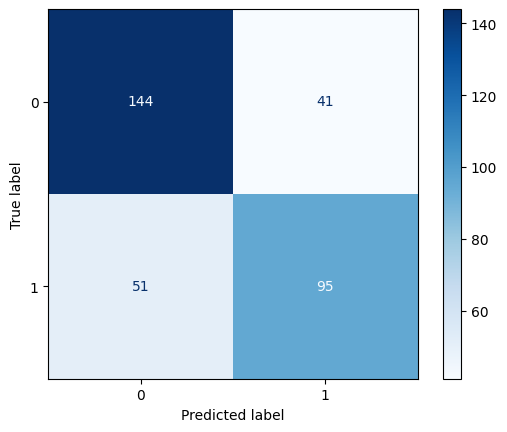

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

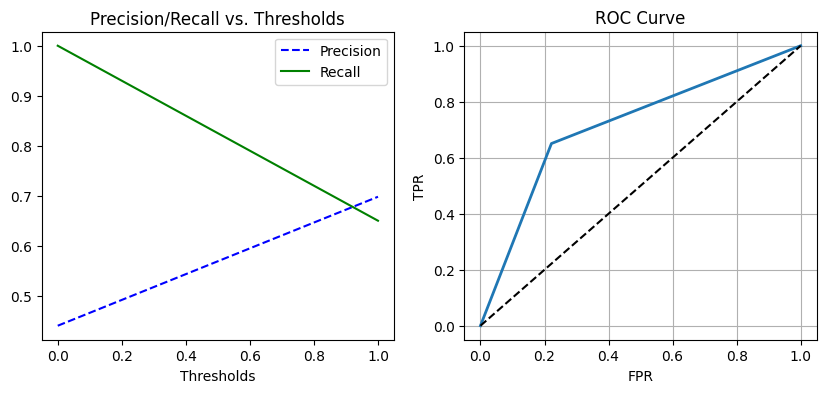

In [50]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [51]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.714531654942614.


#### Test Set

In [52]:
y_pred = cb_clf.predict(X_test)

In [53]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.75.
Recall: 0.7105263157894737.
F1 Score: 0.7297297297297298.


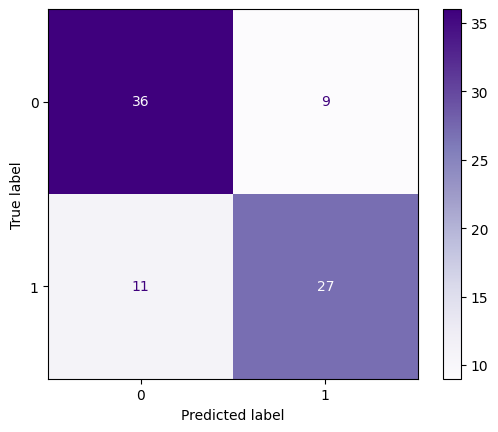

In [54]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [55]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7590361445783133.


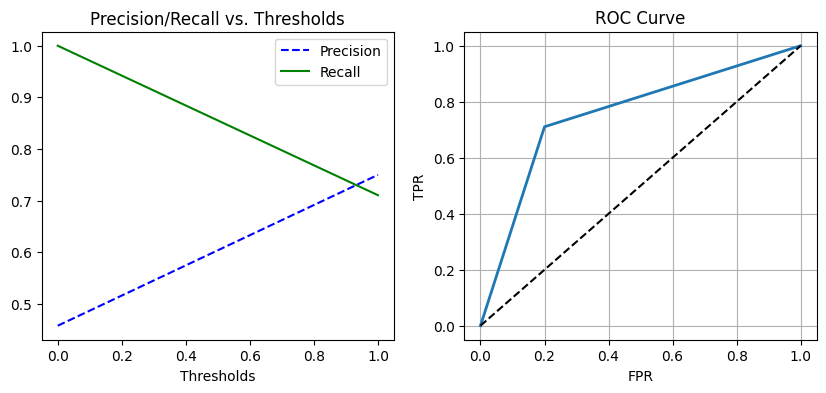

In [56]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [57]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7552631578947369.


In [58]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "CatBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## Logistic Regression

In [59]:
lr_clf = LogisticRegression()
lr_clf

LogisticRegression()

In [60]:
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [61]:
cv_scores = cross_val_score(lr_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.77477477, 0.73636364, 0.67272727])

In [62]:
y_train_pred = cross_val_predict(lr_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.7413793103448276.
Recall: 0.589041095890411.
F1 Score: 0.6564885496183207.


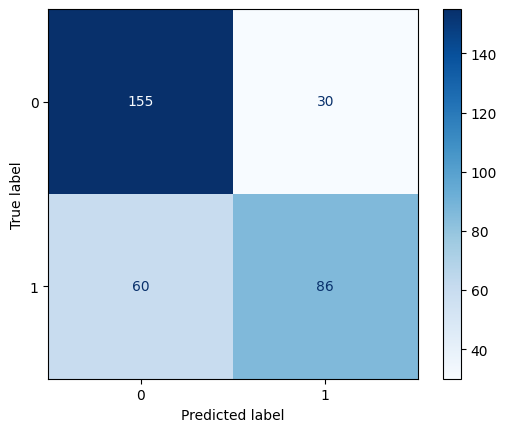

In [63]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

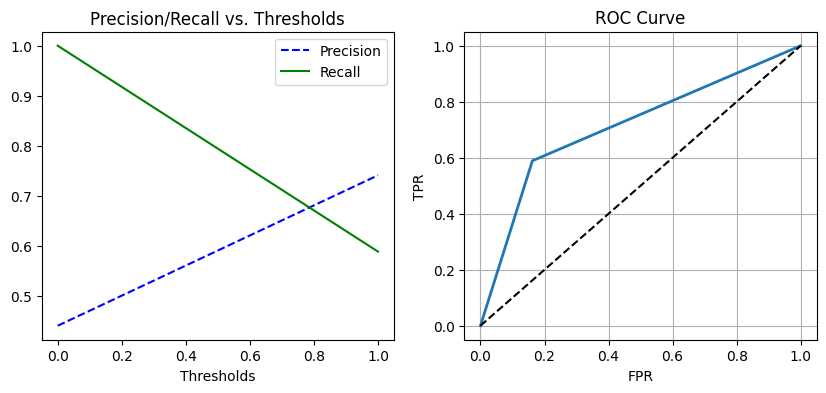

In [64]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [65]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.7134394668641244.


#### Test Set

In [66]:
y_pred = lr_clf.predict(X_test)

In [67]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7647058823529411.
Recall: 0.6842105263157895.
F1 Score: 0.7222222222222222.


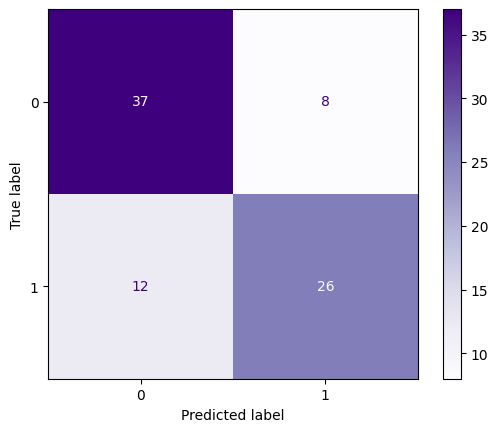

In [68]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [69]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7590361445783133.


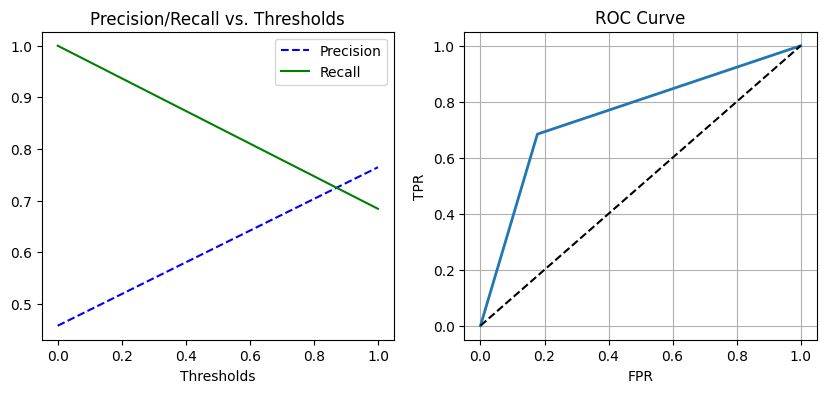

In [70]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [71]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7532163742690058.


In [72]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## Support Vector Machines

In [73]:
svm_clf = SVC(kernel='linear')
svm_clf

SVC(kernel='linear')

In [74]:
svm_clf.fit(X_train, y_train)

SVC(kernel='linear')

In [75]:
cv_scores = cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.73873874, 0.69090909, 0.7       ])

In [76]:
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.7358490566037735.
Recall: 0.5342465753424658.
F1 Score: 0.6190476190476191.


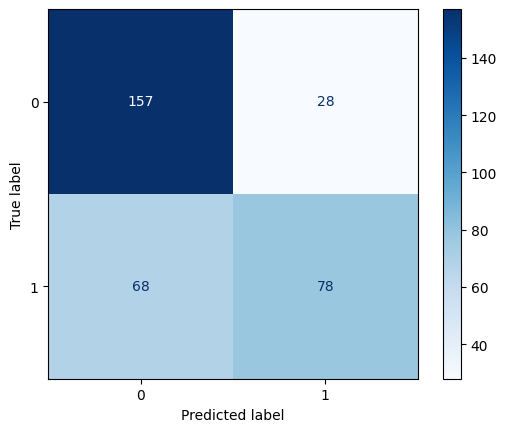

In [77]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

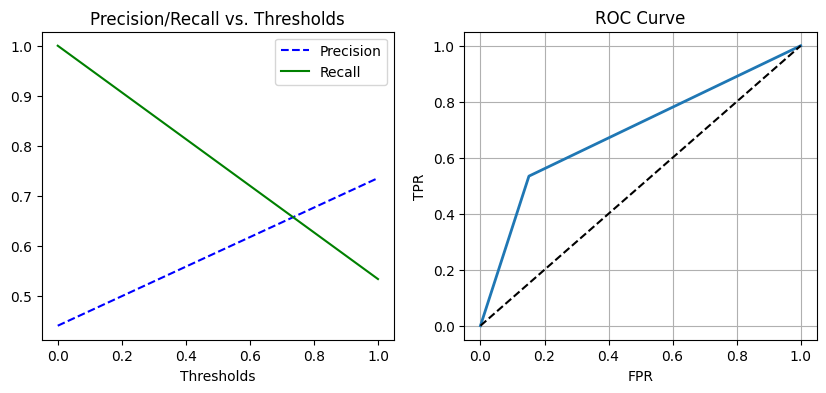

In [78]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

# plt.axvline(x=1.5*np.pi, color='black')
plt.show()

In [79]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6914476119955572.


#### Test Set

In [80]:
y_pred = svm_clf.predict(X_test)

In [81]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7575757575757576.
Recall: 0.6578947368421053.
F1 Score: 0.704225352112676.


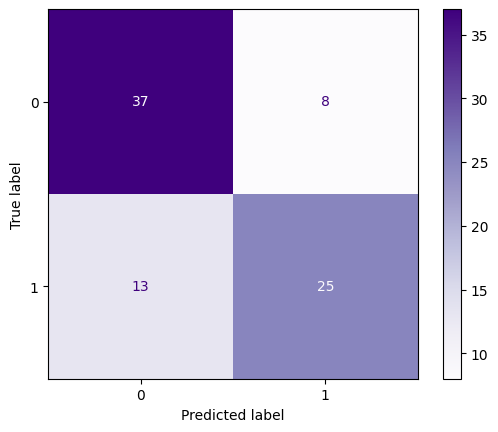

In [82]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [83]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7469879518072289.


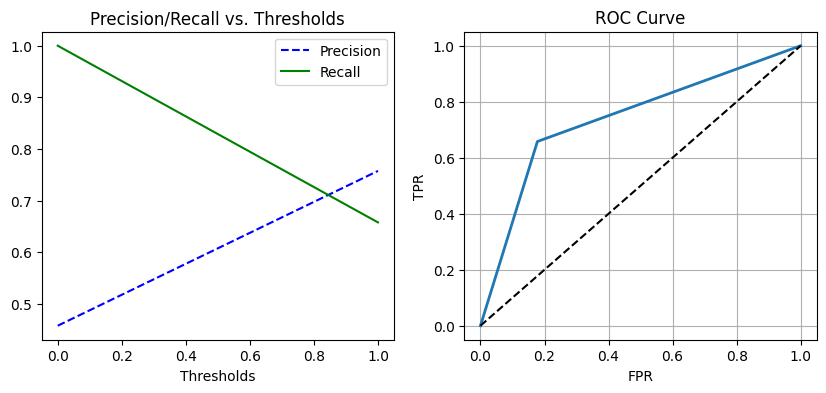

In [84]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [85]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7400584795321637.


In [86]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "SVM",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## Decision Tree

In [87]:
dt_clf = DecisionTreeClassifier()
dt_clf

DecisionTreeClassifier()

In [88]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [89]:
cv_scores = cross_val_score(dt_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.57657658, 0.61818182, 0.60909091])

In [90]:
y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.5531914893617021.
Recall: 0.5342465753424658.
F1 Score: 0.5435540069686411.


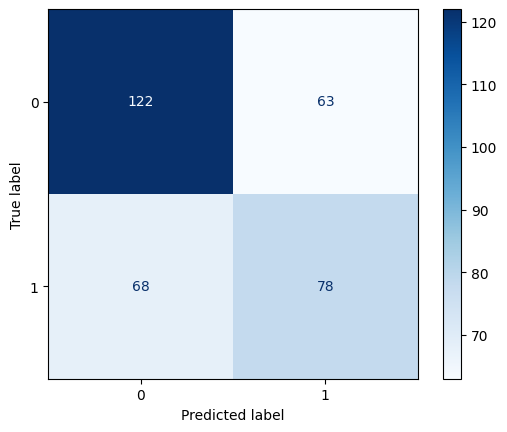

In [91]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

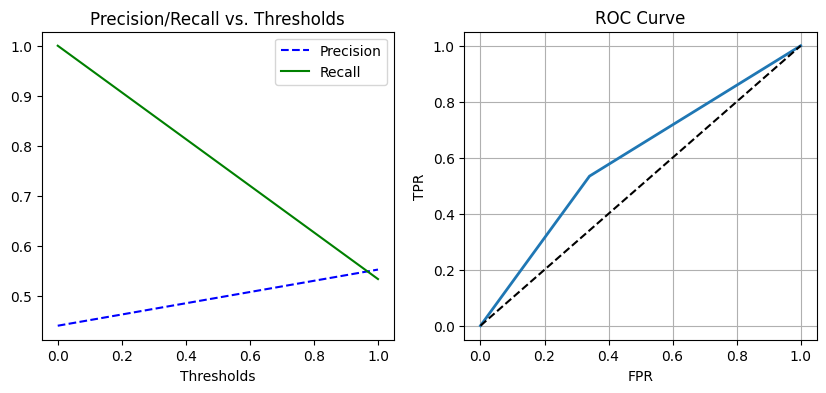

In [92]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [93]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.5968530174009625.


#### Test Set

In [94]:
y_pred = dt_clf.predict(X_test)

In [95]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.6451612903225806.
Recall: 0.5263157894736842.
F1 Score: 0.5797101449275363.


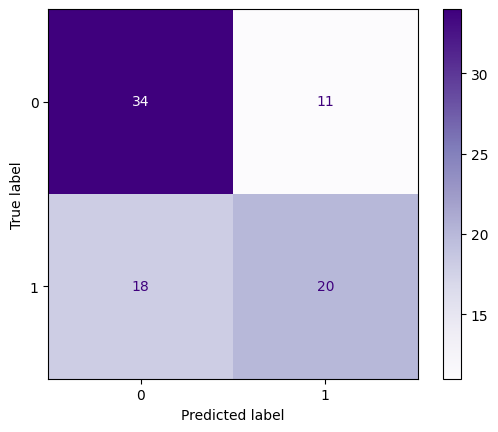

In [96]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [97]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.6506024096385542.


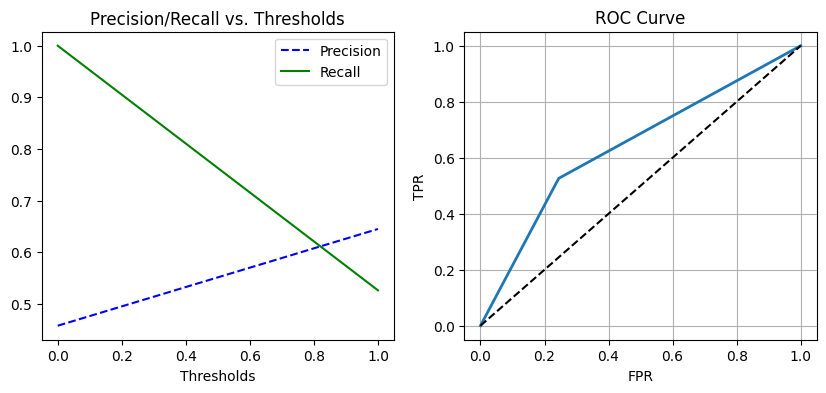

In [98]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [99]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.6409356725146198.


In [100]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## Random Forest

In [101]:
rf_clf = RandomForestClassifier()
rf_clf

RandomForestClassifier()

In [102]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [103]:
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=3, scoring="accuracy")
cv_scores

array([0.7027027 , 0.7       , 0.68181818])

In [104]:
y_train_pred = cross_val_predict(rf_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.689922480620155.
Recall: 0.6095890410958904.
F1 Score: 0.6472727272727273.


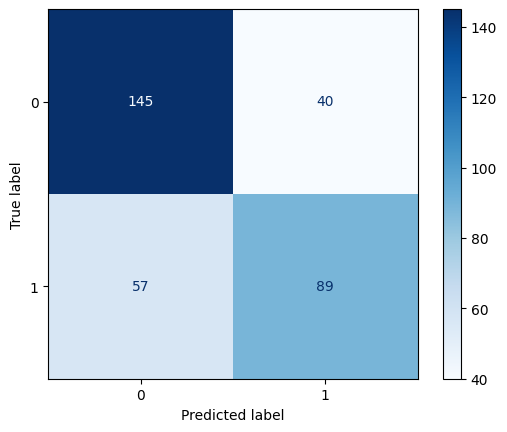

In [105]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

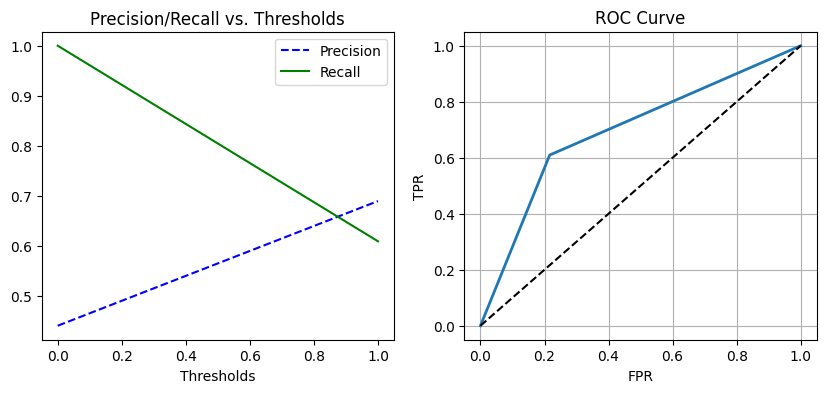

In [106]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [107]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6966864124398371.


#### Test Set

In [108]:
y_pred = rf_clf.predict(X_test)

In [109]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7272727272727273.
Recall: 0.631578947368421.
F1 Score: 0.676056338028169.


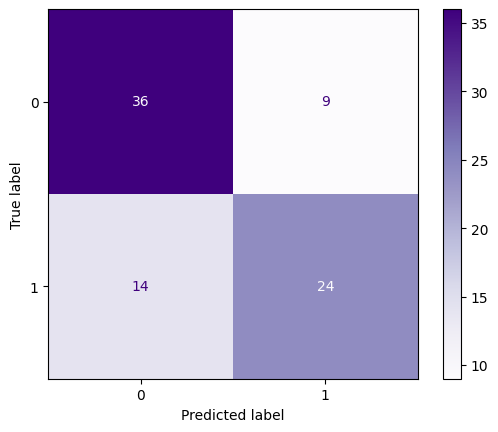

In [110]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [111]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7228915662650602.


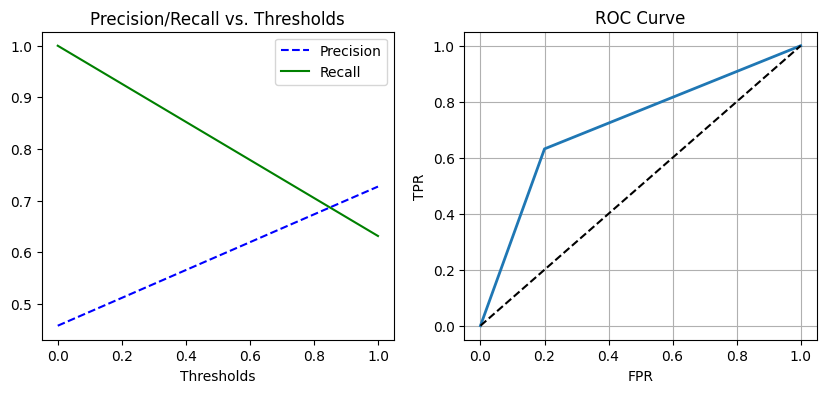

In [112]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [113]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7157894736842105.


In [114]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## XGBoost Classifier

In [115]:
xgb_clf = xgb.XGBClassifier()
xgb_clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [116]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [117]:
cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.63963964, 0.67272727, 0.63636364])

In [118]:
y_train_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6027397260273972.
Recall: 0.6027397260273972.
F1 Score: 0.6027397260273972.


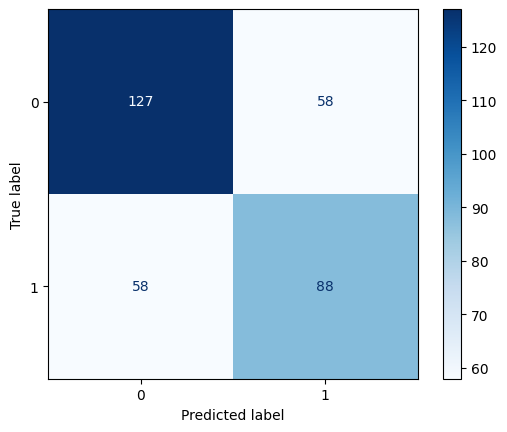

In [119]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

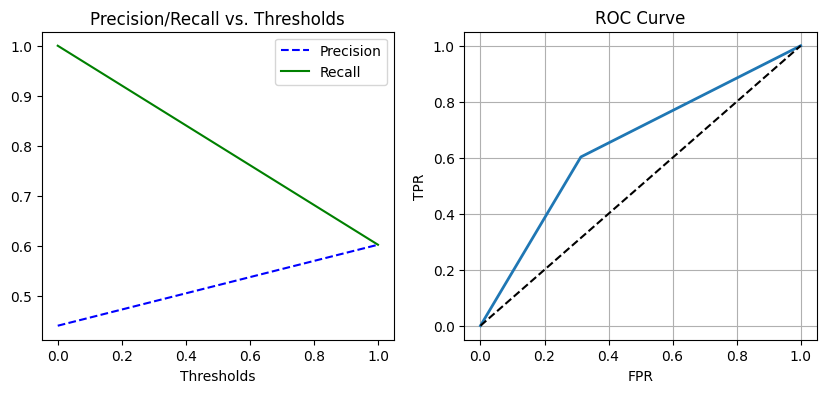

In [120]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [121]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6446131062569418.


#### Test Set

In [122]:
y_pred = xgb_clf.predict(X_test)

In [123]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7272727272727273.
Recall: 0.631578947368421.
F1 Score: 0.676056338028169.


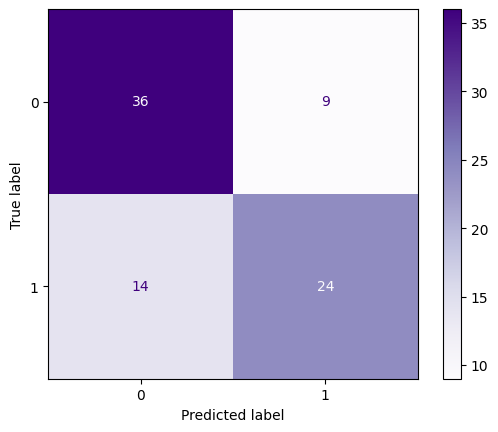

In [124]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [125]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7228915662650602.


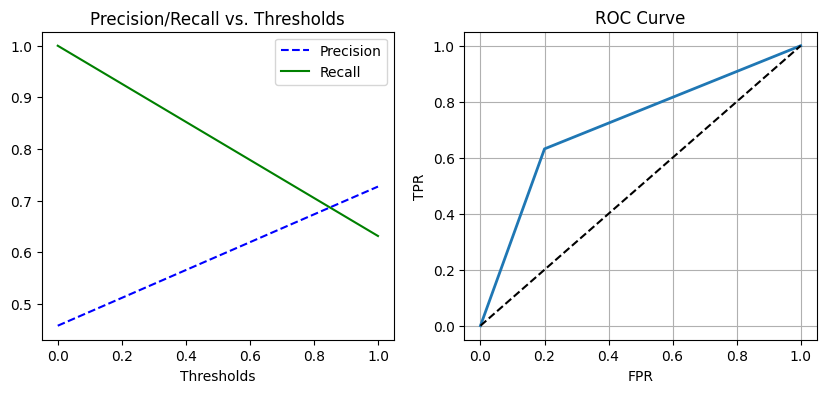

In [126]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [127]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7157894736842105.


In [128]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "XGB",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## MLP Classifier

In [129]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)

In [130]:
mlp_clf.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)

In [131]:
cv_scores = cross_val_score(mlp_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


array([0.7027027 , 0.71818182, 0.69090909])

In [132]:
y_train_pred = cross_val_predict(mlp_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6688741721854304.
Recall: 0.6917808219178082.
F1 Score: 0.68013468013468.


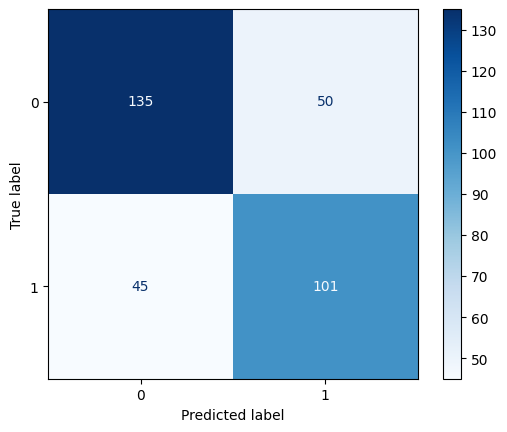

In [133]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

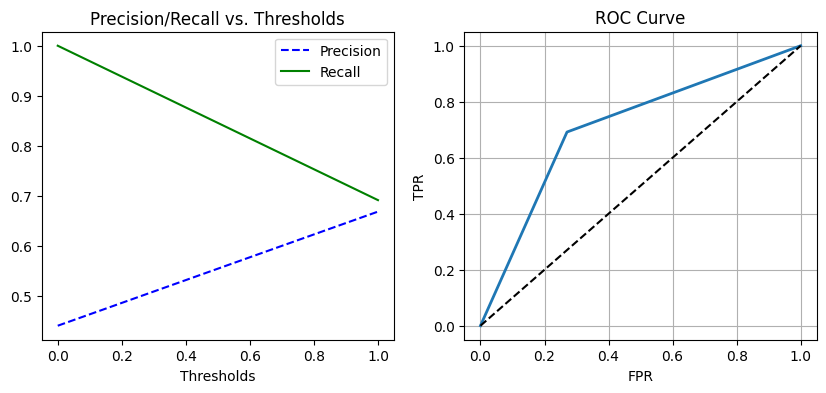

In [134]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [135]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.7107552758237689.


#### Test Set

In [136]:
y_pred = mlp_clf.predict(X_test)

In [137]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7575757575757576.
Recall: 0.6578947368421053.
F1 Score: 0.704225352112676.


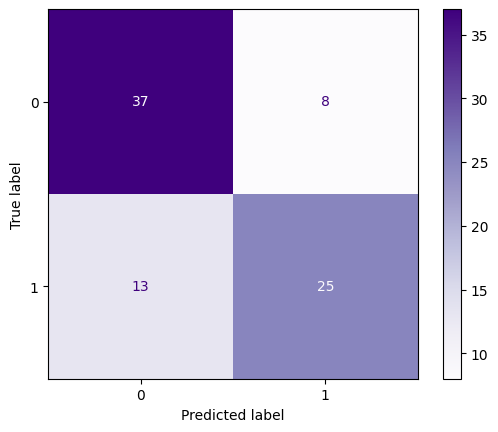

In [138]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [139]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7469879518072289.


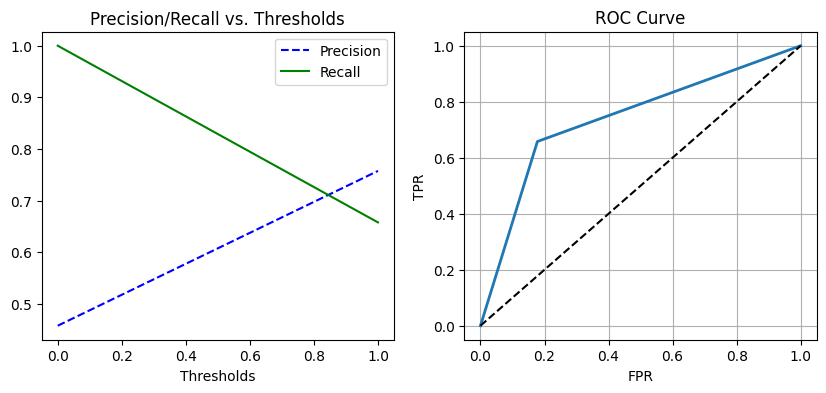

In [140]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [141]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7400584795321637.


In [142]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "MLP",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

## Naive Bayes

In [143]:
nb = GaussianNB()

In [144]:
nb.fit(X_train, y_train)

GaussianNB()

In [145]:
cv_scores = cross_val_score(nb, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.64864865, 0.55454545, 0.62727273])

In [146]:
y_train_pred = cross_val_predict(nb, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.5422885572139303.
Recall: 0.7465753424657534.
F1 Score: 0.6282420749279539.


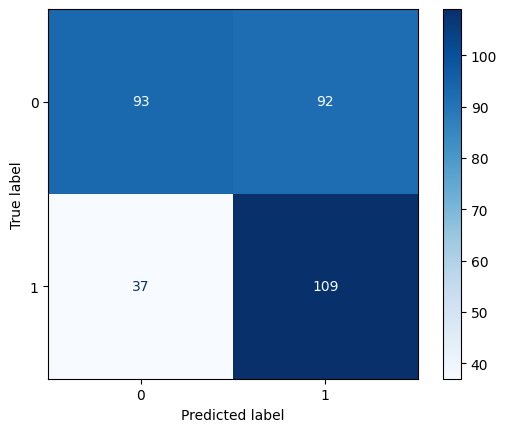

In [147]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

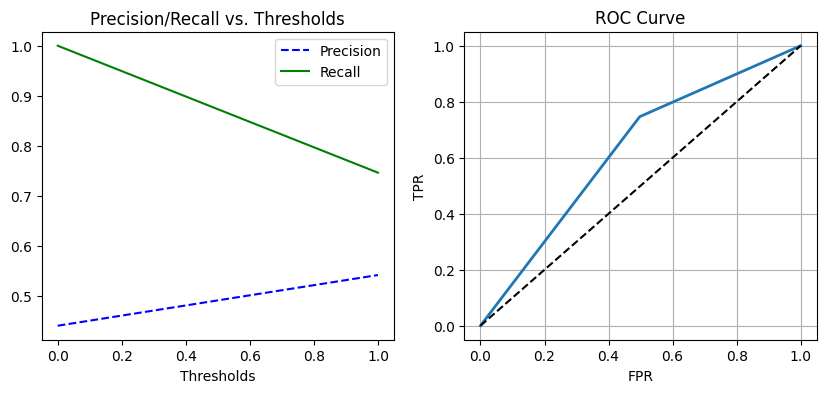

In [148]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [149]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.624639022584228.


#### Test Set

In [150]:
y_pred = nb.predict(X_test)

In [151]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.6875.
Recall: 0.868421052631579.
F1 Score: 0.7674418604651162.


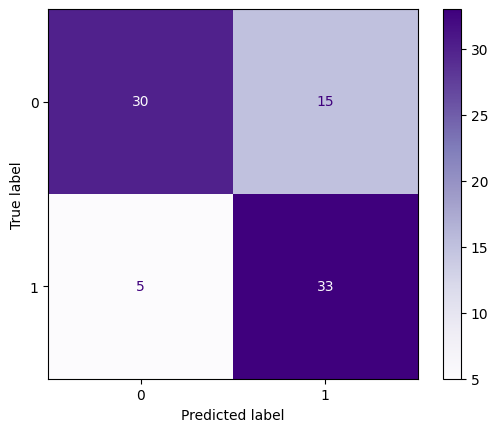

In [152]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [153]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7590361445783133.


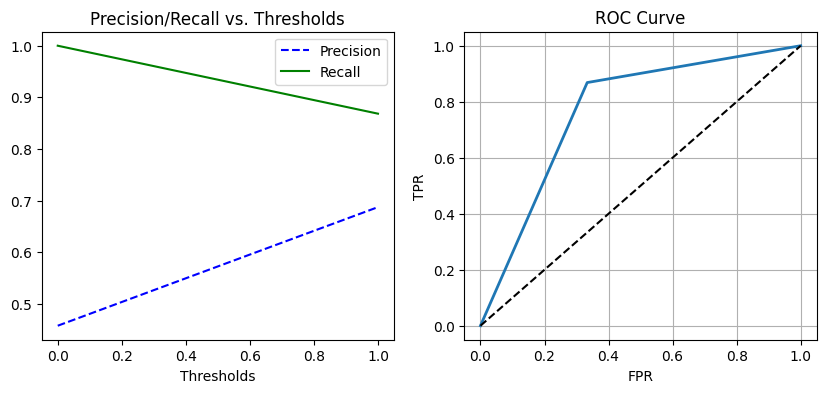

In [154]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [155]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7675438596491229.


In [156]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "NB",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## KNeighbors Classifier

In [160]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [161]:
cv_scores = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.67567568, 0.67272727, 0.73636364])

In [162]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.6618705035971223.
Recall: 0.6301369863013698.
F1 Score: 0.6456140350877192.


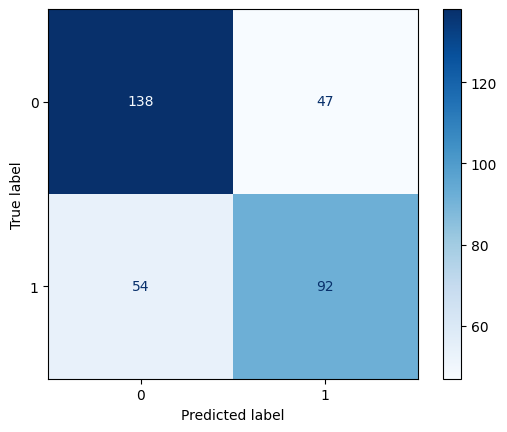

In [163]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

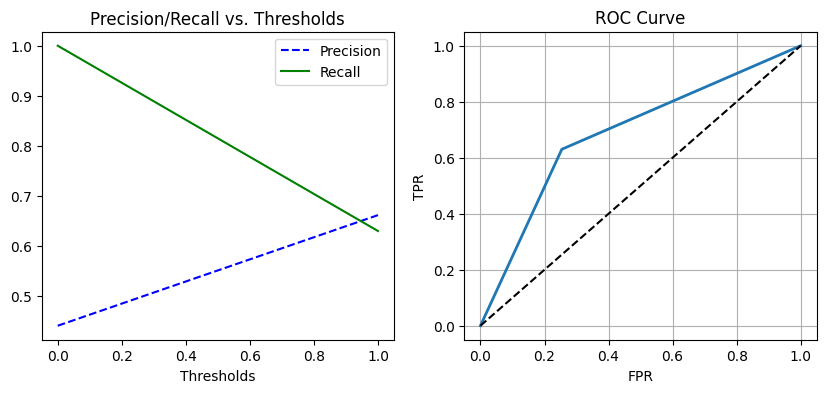

In [164]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [165]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6880414661236578.


#### Test Set

In [166]:
y_pred = knn.predict(X_test)

In [167]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7714285714285715.
Recall: 0.7105263157894737.
F1 Score: 0.7397260273972601.


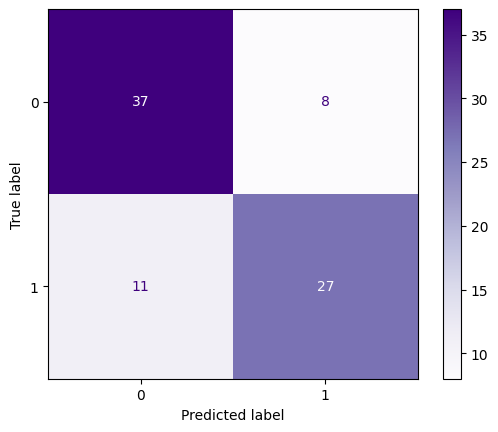

In [168]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [169]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7710843373493976.


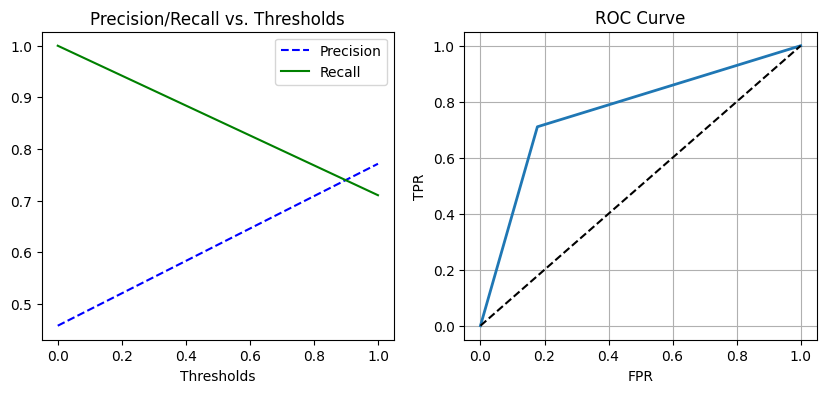

In [170]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [171]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.7663742690058479.


In [172]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "KNN",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## AdaBoost

In [175]:
ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [176]:
cv_scores = cross_val_score(ada_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=False)
cv_scores

array([0.7027027 , 0.63636364, 0.6       ])

In [177]:
y_train_pred = cross_val_predict(ada_clf, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred)}.")
print(f"Recall: {recall_score(y_train, y_train_pred)}.")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")

Precision: 0.60431654676259.
Recall: 0.5753424657534246.
F1 Score: 0.5894736842105264.


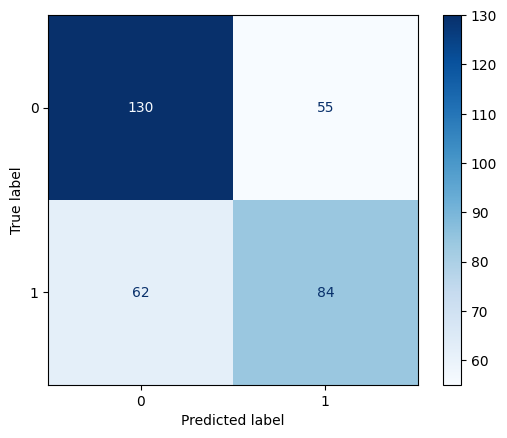

In [178]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Blues')
plt.show()

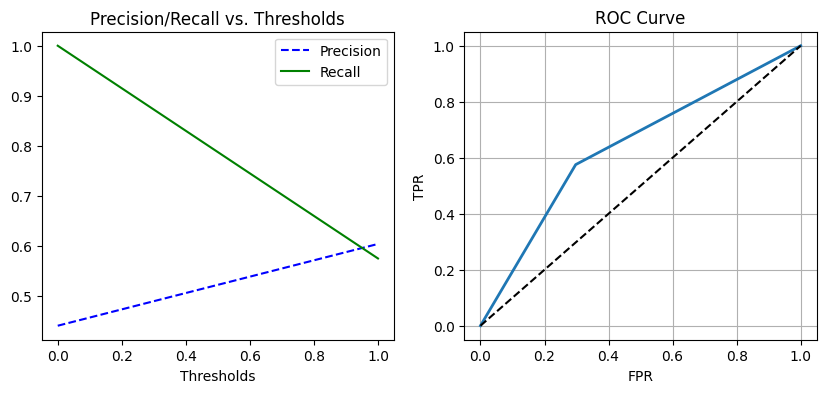

In [179]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [180]:
print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")

AUC: 0.6390225842280637.


#### Test Set

In [181]:
y_pred = ada_clf.predict(X_test)

In [182]:
print(f"Precision: {precision_score(y_test, y_pred)}.")
print(f"Recall: {recall_score(y_test, y_pred)}.")
print(f"F1 Score: {f1_score(y_test, y_pred)}.")

Precision: 0.7941176470588235.
Recall: 0.7105263157894737.
F1 Score: 0.7499999999999999.


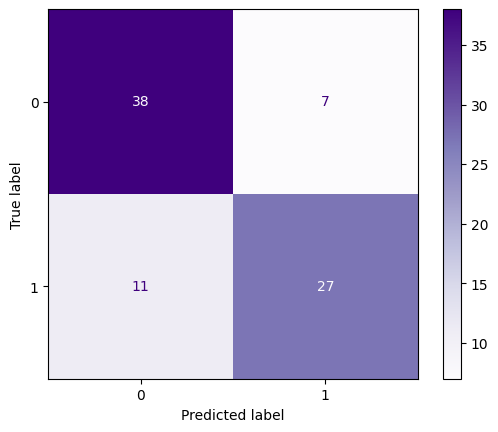

In [183]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
plt.show()

In [184]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")

Accuracy: 0.7831325301204819.


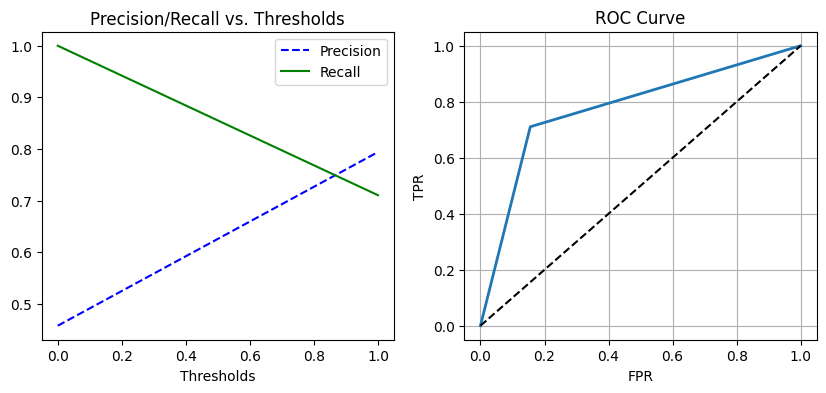

In [185]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
plot_roc_curve(ax2, fpr, tpr)

plt.show()

In [186]:
print(f"AUC: {roc_auc_score(y_test, y_pred)}.")

AUC: 0.777485380116959.


In [187]:
model_scores = pd.concat([model_scores, pd.DataFrame([{
    "Model": "AdaBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred)
}])], ignore_index=True)

___

## Model Scores

In [227]:
model_scores

,Model,Accuracy,AUC
0,SGD,0.807229,0.814035
1,CatBoost,0.759036,0.755263
2,Logistic Regression,0.759036,0.753216
3,SVM,0.746988,0.740058
4,Decision Tree,0.650602,0.640936
5,Random Forest,0.722892,0.715789
6,XGB,0.722892,0.715789
7,MLP,0.746988,0.740058
8,NB,0.759036,0.767544
9,KNN,0.771084,0.766374


In [237]:
model_scores.to_csv("model_scores.csv", index=False)

___

## Predicting Kidney Stone

SGD and AdaBoost were the models with the best numbers, both in accuracy and AUC. We already have instances of those models, so let's just try to predict the test data.

In [198]:
test_data_scaled

array([[-0.20280456, -1.15389851, -1.31346969, ...,  0.59183525,
        -0.78963879,  1.36930639],
       [ 0.25474905, -0.42787688,  0.92868895, ..., -0.36833341,
         1.26640183, -0.73029674],
       [ 0.86482054, -0.95589261,  0.18271557, ..., -0.77879952,
        -0.78963879, -0.73029674],
       ...,
       [ 1.93244564, -0.42787688,  0.92868895, ..., -0.49407494,
         1.26640183, -0.73029674],
       [ 0.10223118, -0.7743872 , -0.47424963, ...,  0.19720776,
        -0.78963879,  1.36930639],
       [-0.20280456,  0.41364819,  0.18271557, ..., -0.33096254,
        -0.78963879, -0.73029674]])

In [243]:
test_id = test_data["id"]

### SGD

In [239]:
predictions_prob = sgd.predict_proba(test_data_scaled)

In [242]:
predictions_prob[:,1][0:10]

array([8.58800139e-04, 7.30801079e-01, 9.99995506e-01, 8.15190268e-02,
       5.06527515e-02, 9.60304915e-01, 2.78580313e-02, 9.99999788e-01,
       1.47720344e-03, 8.03822242e-01])

In [244]:
pd.DataFrame({"id":test_id, "cost":predictions_prob[:,1]}).to_csv("submissionSGD.csv", index=False)

<div style="text-align: center;"><span style="font-size: 24px; font-family: Times New Roman, sans-serif; 
          color: #EEE; background-color: #008CBA">Model Score: 0.78266</span></div>

### AdaBoost

In [245]:
predictions_prob = ada_clf.predict_proba(test_data_scaled)

In [249]:
predictions_prob[:,1][0:10]

array([0.4844661 , 0.50050923, 0.40949342, 0.4934723 , 0.48789436,
       0.50251357, 0.49915936, 0.40375403, 0.49811806, 0.46404656])

In [250]:
pd.DataFrame({"id":test_id, "cost":predictions_prob[:,1]}).to_csv("submissionAda.csv", index=False)

<div style="text-align: center;"><span style="font-size: 24px; font-family: Times New Roman, sans-serif; 
          color: #EEE; background-color: #008CBA">Model Score: 0.32</span></div>

Even though the model was good at predicting, it wasn't so sure about the probabilities. The competition asks for the probabilities, therefore it didn't have a good score.

### Logistic Regression

In [251]:
predictions_prob = lr_clf.predict_proba(test_data_scaled)

In [252]:
predictions_prob[:,1][0:10]

array([0.21086153, 0.28862703, 0.95986126, 0.48906153, 0.35890309,
       0.46154032, 0.42047528, 0.8100244 , 0.20461145, 0.48475943])

In [253]:
pd.DataFrame({"id":test_id, "cost":predictions_prob[:,1]}).to_csv("submissionLR.csv", index=False)

<div style="text-align: center;"><span style="font-size: 24px; font-family: Times New Roman, sans-serif; 
          color: #EEE; background-color: #008CBA">Model Score: 0.76533</span></div>